[![image.png](https://i.postimg.cc/Df6QS0kf/image.png)](https://postimg.cc/s1BG8Vgb)

<div style="padding:20px 20px 20px; 
            color:#004346;
            font-size:40px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 
<p style="font-weight: bold; text-align: center;">Оценка риска ДТП</p>

</div>

<div style="padding:0px 40px 30px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
    
__Заказчик:__ Каршеринговая компания.
    
__Постановка задачи:__ Разработать систему, которая может оценить риск ДТП по выбранному маршруту движения для водителей, которые арендуют автомобили.
    
__Описание задачи:__  Система должна предсказывать вероятность возникновения ДТП с любым повреждением транспортного средства. При выборе маршрута и совершении бронирования автомобиля, водителю будет предоставляться оценка уровня риска. В случае высокого уровня риска, водитель получит предупреждение и рекомендации по выбору безопасного маршрута.
    
__Оценка результата:__ Качество системы будет оцениваться на основе точности предсказаний.
    
__Описание данных:__ Исторические данные, предоставленные заказчиком, включают информацию о маршрутах движения, участниках ДТП, условиях происшествия, состоянии дороги и факте о виновности водителя в происшествии. 
    
</div>    

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Используемые библиотеки

</div>

In [771]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import phik
import psycopg2
import sqlalchemy
from sqlalchemy import create_engine

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score
import optuna
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from skorch.classifier import NeuralNetClassifier
from skorch.dataset import ValidSplit
from skorch.callbacks import EpochScoring, EarlyStopping
from sklearn.model_selection import cross_val_score

import shap
from sklearn.metrics import confusion_matrix

# константы
RANDOM_SEED = 42
SPLITS = 4

# настройки блокнота
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

## Подключение к базе данных

In [409]:
# конфигурация для подключения к базе данных
db_config = {
'user': 'praktikum_student', # имя пользователя
'pwd': 'Sdf4$2;d-d30pp', # пароль
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения
'db': 'data-science-vehicle-db' # название базы данных
} 

# создание подключения к базе данных
connection = psycopg2.connect(
    user=db_config['user'],
    password=db_config['pwd'],
    host=db_config['host'],
    port=db_config['port'],
    database=db_config['db']
)

# создаем курсора для выполнения запросов
cursor = connection.cursor()

#### функция для выполнения запросов

In [410]:
# функция для выполнения запросов
def request(query):
    try:
        cursor.execute(query)
        result = cursor.fetchall()
        result_df = pd.DataFrame(result, columns=[desc[0] for desc in cursor.description])
        return result_df
    except Exception as e:
        print(f'Error: {e}')
        connection.rollback()  # откат транзакции, для избежания блокировки

In [411]:
# тестовый запрос
query = '''
SELECT case_id, county_city_location, county_location, distance, direction
FROM collisions
LIMIT 1;
'''
display(request(query))

,case_id,county_city_location,county_location,distance,direction
0,4083072,1942,los angeles,528.0,north


<div style="padding: 30px 25px; border: 2px #6495ed solid">

- Подключение к базе данных успешно установлено.
- Функция для выполнения запросов работает корректно.
    
</div>

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Первичное исследование таблиц базы данных

</div>

- Проверим все ли таблицы имеют набор данных;
- Посмотрим количество таблиц;
- Имеется ли общий ключ для связи таблиц.

In [412]:
# создание engine для подключения к базе данных
engine = sqlalchemy.create_engine(
    f"postgresql://{db_config['user']}:{db_config['pwd']}@{db_config['host']}:{db_config['port']}/{db_config['db']}"
)
# получение метаданных таблицы
metadata = sqlalchemy.MetaData()
metadata.reflect(bind=engine)

__Общая информация о таблицах__

In [413]:
for table_name, table in metadata.tables.items():
    query = f'SELECT COUNT(*) FROM {table_name};'
    print(f'''
Таблица: {table_name};
Количество записей: {request(query).iloc[0][0]};
Признаки: {table.columns.keys()};
Первичный ключ: {table.primary_key.columns.keys() if table.primary_key else 'Отсутствует'}     
           ''')


Таблица: case_ids;
Количество записей: 1400000;
Признаки: ['case_id', 'db_year'];
Первичный ключ: Отсутствует     
           

Таблица: collisions;
Количество записей: 1400000;
Признаки: ['case_id', 'county_city_location', 'county_location', 'distance', 'direction', 'intersection', 'weather_1', 'location_type', 'collision_damage', 'party_count', 'primary_collision_factor', 'pcf_violation_category', 'type_of_collision', 'motor_vehicle_involved_with', 'road_surface', 'road_condition_1', 'lighting', 'control_device', 'collision_date', 'collision_time'];
Первичный ключ: Отсутствует     
           

Таблица: parties;
Количество записей: 2752408;
Признаки: ['id', 'case_id', 'party_number', 'party_type', 'at_fault', 'insurance_premium', 'party_sobriety', 'party_drug_physical', 'cellphone_in_use'];
Первичный ключ: Отсутствует     
           

Таблица: vehicles;
Количество записей: 1021234;
Признаки: ['id', 'case_id', 'party_number', 'vehicle_type', 'vehicle_transmission', 'vehicle_age'];
П

<div style="padding: 30px 25px; border: 2px #6495ed solid">

- В базе данных есть три основные таблицы, c наборами данных, но без явно указанных первичных ключей.

- Таблица __'collisions'__ — общая информация о ДТП:
    - Из описания данных известно, имеет уникальный `case_id`, который является уникальным идентификатором для каждого зарегистрированного происшествия;
    - Эта таблица содержит общую информацию о происшествии, включая место, дату и время его происхождения, погодные условия, серьезность происшествия и другие характеристики.
    
- Таблица __'parties'__ — информация об участниках ДТП:
    - Имеет неуникальный `case_id`, который связан с соответствующим ДТП в таблице 'collisions'.
    - Каждая строка в этой таблице описывает одну из сторон, участвующих в ДТП. Например, если в ДТП участвуют две машины, то в этой таблице будет две строки с совпадающим `case_id`.
    - Для создания уникального идентификатора участника можно использовать комбинацию `case_id` и `party_number`.

- Таблица __'vehicles'__ — информация о пострадавших машинах:
    - Имеет неуникальные `case_id` и неуникальные `party_number`, которые связаны с таблицами 'collisions' и 'parties'.
    - Данная таблица содержит информацию о пострадавших машинах, и каждая строка описывает одно транспортное средство.
    - Для создания уникального идентификатора машины можно использовать комбинацию `case_id` и `party_number`.


</div>

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Анализ факторов ДТП

</div>

## Зависимость количества аварий от месяца

In [414]:
# sql запрос
query = '''
SELECT CAST(EXTRACT(MONTH FROM COLLISION_DATE) AS INTEGER) AS month_num,
       TO_CHAR(COLLISION_DATE, 'Month') AS month,
       COUNT(*) AS collision_count
FROM collisions
GROUP BY month, month_num
ORDER BY month_num;
'''

df = request(query)
display(df)

,month_num,month,collision_count
0,1,January,132044
1,2,February,128858
2,3,March,139581
3,4,April,130180
4,5,May,130316
5,6,June,102594
6,7,July,102227
7,8,August,104089
8,9,September,105159
9,10,October,112237


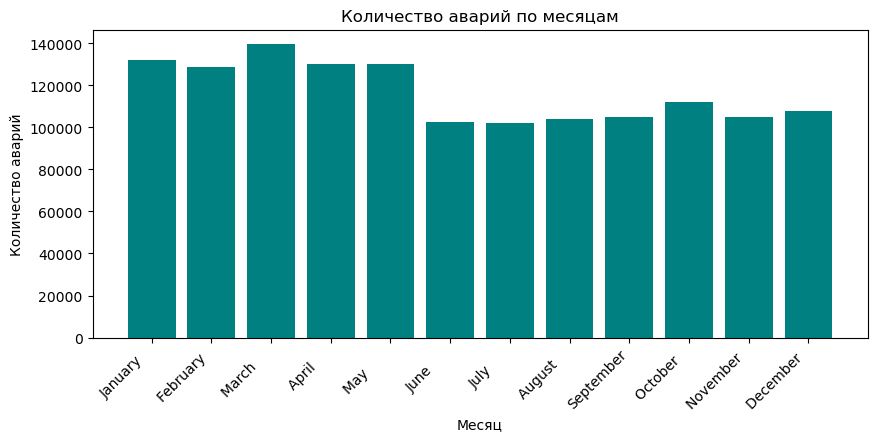

In [415]:
# визуолизация результатов
plt.figure(figsize=(10, 4))
plt.bar(df['month'], df['collision_count'], color='teal')
plt.xlabel('Месяц')
plt.ylabel('Количество аварий')
plt.title('Количество аварий по месяцам')
plt.xticks(rotation=45, ha='right')
plt.show()

- Видно, что количество аварий имеет явные сезонные колебания в течение года.
- Наибольшее количество аварий обычно происходит в марте и октябре, что может быть связано с изменениями погоды и дорожных условий в эти месяцы.
- Наименьшее количество аварий зафиксировано в июне и июле, возможно, из-за летнего сезона и лучших дорожных условий.
- Аварийное количество кажется стабильным в период с августа по декабрь.

## Аналитические задачи

Эти задачи позволят лучше понять данные и провести дополнительный анализ для определения факторов, влияющих на возникновение ДТП, а также выявить потенциальные меры для предотвращения аварий.


__Задача 1:__

__Анализ серьезности повреждений транспортного средства, исходя из состояния дороги в момент ДТП.__
- Исследовать связь между состоянием дороги (ROAD_SURFACE) в момент ДТП и серьезностью повреждений транспортного средства (COLLISION_DAMAGE). 
- Определить, какие состояния дороги преобладают при различных уровнях серьезности повреждений, и сделайте выводы о влиянии состояния дороги на серьезность ДТП.

__Задача 2:__

__Анализ частых причин ДТП.__
- Используя таблицу "parties", определить самые частые причины ДТП (PCF_VIOLATION_CATEGORY). 
- Выстроить рейтинг причин в порядке убывания частоты аварий. 
- Определить рекомендации на основе этого анализа, чтобы предотвратить наиболее распространенные типы ДТП.

__Задача 3:__

__Анализ влияния уровня освещения на вероятность возникновения ДТП.__
- Сравнить количество ДТП в зависимости от уровня освещения (LIGHTING). 
- Определить, в какое время суток и в каких условиях освещения ДТП происходят наиболее часто. 
- Проанализировать, как уровень освещения влияет на вероятность возникновения ДТП.

__Задача 4:__

__Анализ распределения количества участников в ДТП.__
- Изучить количество участников (PARTY_COUNT) в каждом ДТП и определите распределение этой величины. 
- Определить, как часто происходят ДТП с большим количеством участников и сравните это с количеством ДТП с небольшим числом участников.

__Задача 5:__

__Анализ зависимости вероятности возникновения ДТП от погодных условий.__
- Изучить влияние погодных условий (WEATHER_1) на вероятность возникновения ДТП. 
- Сравнить количество ДТП в различных погодных условиях и определите, какие погодные условия сопровождаются наибольшим риском возникновения аварий.

__Задача 6:__

__Анализ влияния уровня опьянения участников на тяжесть ДТП.__
- Исследовать связь между уровнем опьянения участников ДТП (PARTY_SOBRIETY) и серьезностью аварий (COLLISION_DAMAGE). 
- Определить, какие уровни опьянения преобладают при различных уровнях серьезности повреждений транспортного средства. 
- Сравнить количество исходящихся аварий для каждого уровня опьянения и выявите, насколько опьянение участников влияет на тяжесть ДТП.

__Задача 7:__
__Анализ частоты ДТП в зависимости от времени суток и сотоянии дороги.__
- Объединить таблицы "collisions" и "vehicles" по общему ключу "case_id".
- Используя полученные данные для вычисления количества ДТП для каждого времени суток (утро, день, вечер, ночь) и типа дороги (городская, загородная, автострада).

__Задача 8:__
__Анализ влияния возраста автомобиля на тип аварий__
- Объединить таблицы "collisions" и " vehicles" по общему ключу "case_id" и получить данные о типах ДТП и возрасте автомобилей.
- Используя полученные данные, проанализируйте селичество и тип ДТП и связь их и возрастом автомобилей.

### Анализ частых причин ДТП.
Данный анализ поможет сосредоточить внимание на наиболее значимых проблемах и разработать эффективные стратегии для снижения аварийности и повышения безопасности на дорогах.

In [416]:
# sql запрос
query = '''
SELECT PCF_VIOLATION_CATEGORY, 
       COUNT(*) AS collision_count
FROM collisions
GROUP BY PCF_VIOLATION_CATEGORY
ORDER BY collision_count DESC
LIMIT 10;
'''

df = request(query)
display(df)

,pcf_violation_category,collision_count
0,speeding,438439
1,improper turning,238987
2,automobile right of way,158291
3,dui,110476
4,unsafe lane change,93962
5,traffic signals and signs,72751
6,unsafe starting or backing,55674
7,unknown,39558
8,wrong side of road,33631
9,following too closely,30033


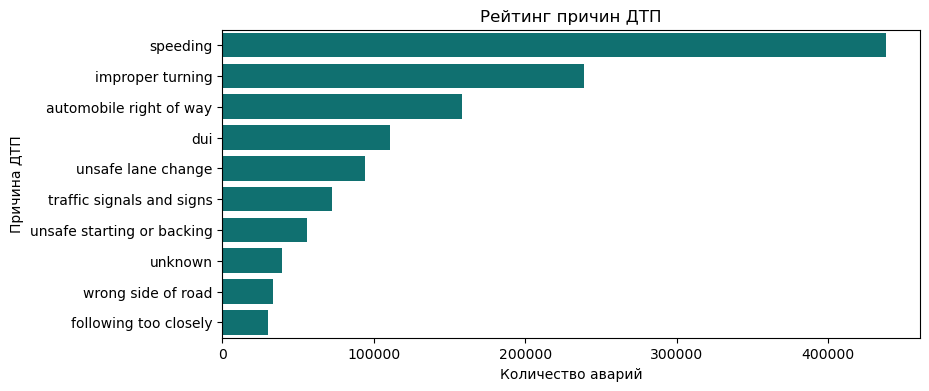

In [417]:
# визуолизация результатов
plt.figure(figsize=(9, 4))
sns.barplot(x='collision_count', y='pcf_violation_category', data=df, color='teal')
plt.xlabel('Количество аварий')
plt.ylabel('Причина ДТП')
plt.title('Рейтинг причин ДТП')
plt.show()

__Из результатов запроса видно, что самыми частыми причинами ДТП в данной базе данных являются:__
- Превышение скорости (Speeding) - 438,439 аварий.
- Неправильный поворот (Improper Turning) - 238,987 аварий.
- Автомобильное право проезда (Automobile Right of Way) - 158,291 аварий.
- Вождение или езда на велосипеде в состоянии алкогольного или наркотического опьянения (DUI - Driving Under the Influence) - 110,476 аварий.

__Основываясь на этом анализе, можно предложить следующие рекомендации для предотвращения наиболее распространенных типов ДТП:__
- Повышать осведомленность и образованность водителей: Продвигать информационные кампании, обучающие водителей о безопасных практиках вождения, в том числе о соблюдении ограничений скорости и правильном повороте.
- Развивать системы контроля скорости: Внедрение автоматических систем контроля скорости на дорогах может снизить количество ДТП, связанных с превышением скорости.
- Расширить сеть камер наблюдения на дорогах: Установка камер на опасных участках дорог поможет отслеживать нарушения и устранять их.
- Поддерживать безопасные дорожные условия: Проводить регулярный мониторинг дорожного покрытия и инфраструктуры, чтобы обеспечить безопасное движение.
- Установить технологию, которая интегрирует алко-тест в систему зажигания автомобиля. Это поможет предотвращать аварии, связанные с вождением в состоянии алкогольного опьянения.

### Анализ зависимости вероятности возникновения ДТП от погодных условий.

In [418]:
# sql запрос
query = '''
SELECT WEATHER_1,
       COUNT(*) AS collision_count
FROM collisions
GROUP BY WEATHER_1
ORDER BY collision_count DESC;
'''

df = request(query)
display(df)

,weather_1,collision_count
0,clear,1121048
1,cloudy,203030
2,raining,57976
3,None,7259
4,fog,6156
5,snowing,2571
6,other,1516
7,wind,444


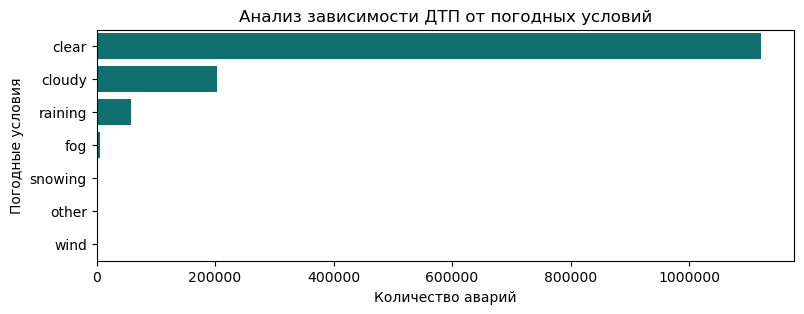

In [419]:
# визуолизация результатов
plt.figure(figsize=(9, 3))
sns.barplot(x='collision_count', y='weather_1', data=df, color='teal')
plt.xlabel('Количество аварий')
plt.ylabel('Погодные условия')
plt.title('Анализ зависимости ДТП от погодных условий')
plt.ticklabel_format(style='plain', axis='x')

plt.show()

__На основе результатов анализа зависимости вероятности возникновения ДТП от погодных условий, получены следующие данные:__
- В ясную погоду (clear) зарегистрировано наибольшее количество аварий - 1,121,048 случаев.
- За ясной погодой следует облачная погода (cloudy) с 203,030 авариями.
- Дождливая погода (raining) оказывается третьей по частоте причиной ДТП с 57,976 авариями.
- В условиях без указания погоды (None) произошло 7,259 аварий.
- Туман (fog) сопровождается 6,156 авариями.
- В снежную погоду (snowing) попало 2,571 аварий.
- Другие погодные условия (other) были отмечены в 1,516 случаев.
- Ветрено (wind) связано с 444 авариями.

__На основе этих результатов можно сделать следующие выводы рекомендации:__
- В ясную погоду произошли большинство оварий, что говорит, о там, что другие факторы могут оказать большее влияние на риск аварии.
- При вождении в облачную погоду и дождь также необходимо соблюдать повышенную осторожность и соблюдать дистанцию.
- В условиях тумана и снегопада водителям следует снизить скорость движения, использовать фары и габариты, чтобы быть видимыми другим участникам дорожного движения.


### Анализ влияния возраста автомобиля на тип аварий
Для более удобного анализа, автомобили были разделены на две категории: "Новые" - автомобили возрастом менее или равно 5 лет, и "Старые" - автомобили старше 5 лет.

In [420]:
# sql запрос
query = '''
SELECT 
    CASE
        WHEN VEHICLE_AGE > 5 THEN 'Старые автомобили'
        ELSE 'Новые автомобили'
    END AS vehicle_category,
    TYPE_OF_COLLISION,
    COUNT(*) AS collision_count
FROM collisions c
     JOIN vehicles v ON c.CASE_ID = v.CASE_ID
WHERE VEHICLE_AGE IS NOT NULL AND
      TYPE_OF_COLLISION IS NOT NULL
GROUP BY vehicle_category, TYPE_OF_COLLISION
ORDER BY vehicle_category, collision_count DESC;
'''

df = request(query)
display(df)

,vehicle_category,type_of_collision,collision_count
0,Новые автомобили,rear end,210736
1,Новые автомобили,broadside,143999
2,Новые автомобили,sideswipe,75521
3,Новые автомобили,hit object,72027
4,Новые автомобили,other,41445
5,Новые автомобили,head-on,30937
6,Новые автомобили,overturned,18089
7,Старые автомобили,rear end,151661
8,Старые автомобили,broadside,98836
9,Старые автомобили,sideswipe,48290


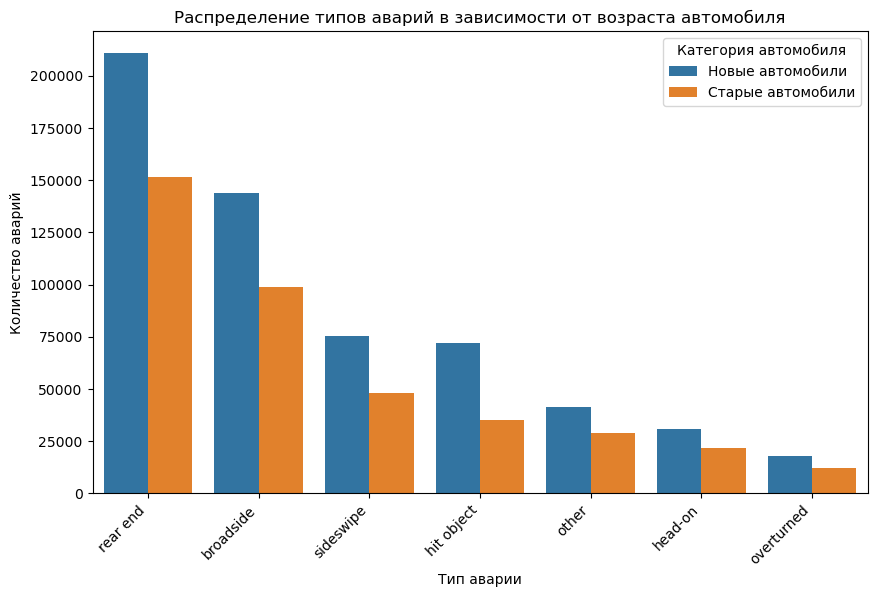

In [421]:
# визуолизация результатов
plt.figure(figsize=(10, 6))
sns.barplot(x='type_of_collision', y='collision_count', hue='vehicle_category', data=df)
plt.xlabel('Тип аварии')
plt.ylabel('Количество аварий')
plt.title('Распределение типов аварий в зависимости от возраста автомобиля')
plt.legend(title='Категория автомобиля', loc='upper right')
plt.xticks(rotation=45, ha='right')
plt.show()

- Проведенный анализ показывает, что независимо от возрастной категории автомобилей, самыми частыми типами аварий являются "rear end" (столкновение сзади) и "broadside" (боковое столкновение). При этом количество столкновений в категории "Старые автомобили" ниже, чем в категории "Новые автомобили". Однако, это можно объяснить общим количеством старых автомобилей, которые могут быть менее представлены на дорогах по сравнению с новыми автомобилями.

- Важно обратить внимание, что типы аварий остаются стабильными независимо от возраста автомобилей, что подчеркивает необходимость предоставления дополнительного внимания на профилактику  по предотвращению столкновений сзади и боковых столкновений, так как они являются наиболее распространенными.


### Анализ частоты ДТП в зависимости от времени суток и состояния дороги.

In [422]:
# sql запрос
query = '''
SELECT 
    CASE 
        WHEN EXTRACT(HOUR FROM collision_time) >= 0 AND EXTRACT(HOUR FROM collision_time) < 6 THEN 'Ночь'
        WHEN EXTRACT(HOUR FROM collision_time) >= 6 AND EXTRACT(HOUR FROM collision_time) < 12 THEN 'Утро'
        WHEN EXTRACT(HOUR FROM collision_time) >= 12 AND EXTRACT(HOUR FROM collision_time) < 18 THEN 'День'
        WHEN EXTRACT(HOUR FROM collision_time) >= 18 AND EXTRACT(HOUR FROM collision_time) < 24 THEN 'Вечер'
    END AS time_of_day,
    road_surface,
    COUNT(*) AS collision_count
FROM collisions c
     JOIN vehicles v ON c.case_id = v.case_id
WHERE road_surface IS NOT NULL AND collision_time IS NOT NULL
GROUP BY time_of_day, road_surface
ORDER BY time_of_day, collision_count DESC;
'''

df = request(query)
display(df)

,time_of_day,road_surface,collision_count
0,Вечер,dry,212148
1,Вечер,wet,20743
2,Вечер,snowy,941
3,Вечер,slippery,179
4,День,dry,415081
5,День,wet,33386
6,День,snowy,1708
7,День,slippery,330
8,Ночь,dry,63079
9,Ночь,wet,8966


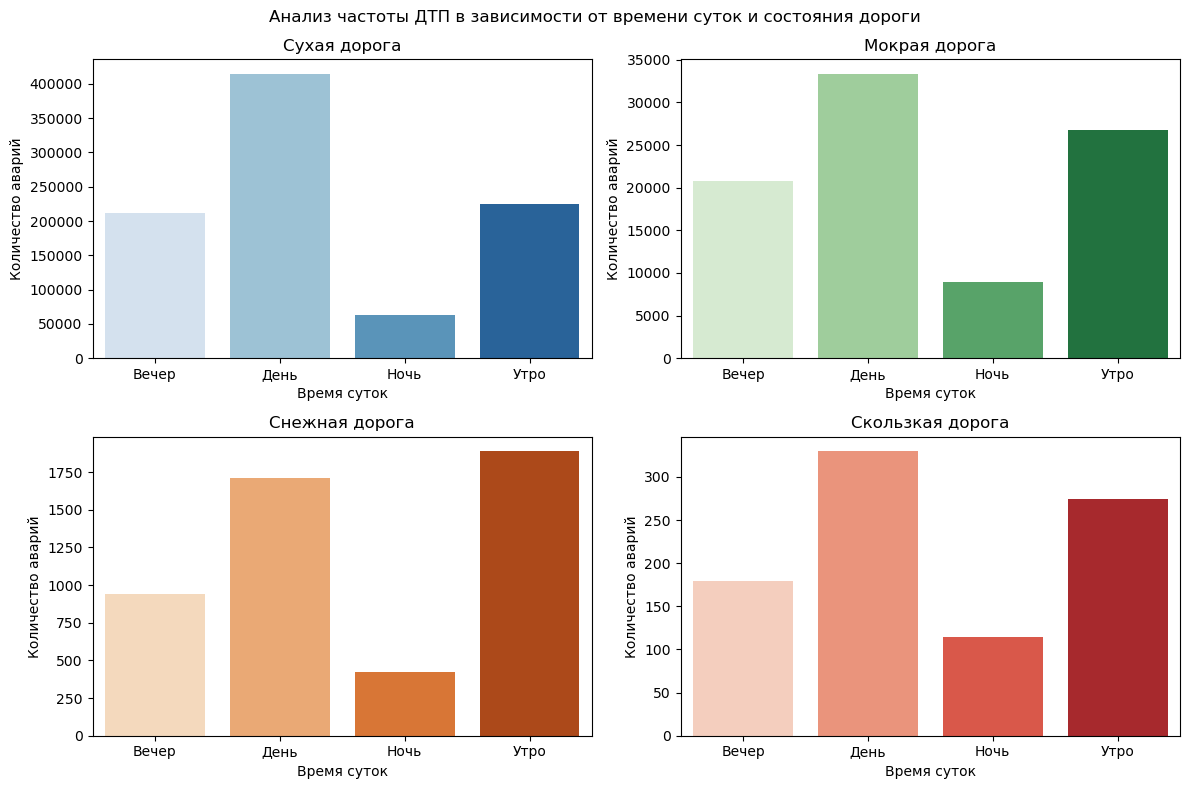

In [423]:
# визуолизация результатов
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Анализ частоты ДТП в зависимости от времени суток и состояния дороги')

sns.barplot(x='time_of_day',
            y='collision_count',
            data=df[df['road_surface'] == 'dry'],
            ax=axes[0, 0],
            palette='Blues')
axes[0, 0].set_title('Сухая дорога')
axes[0, 0].set_xlabel('Время суток')
axes[0, 0].set_ylabel('Количество аварий')

sns.barplot(x='time_of_day',
            y='collision_count',
            data=df[df['road_surface'] == 'wet'],
            ax=axes[0, 1],
            palette='Greens')
axes[0, 1].set_title('Мокрая дорога')
axes[0, 1].set_xlabel('Время суток')
axes[0, 1].set_ylabel('Количество аварий')

sns.barplot(x='time_of_day', 
            y='collision_count', 
            data=df[df['road_surface'] == 'snowy'], 
            ax=axes[1, 0], 
            palette='Oranges')
axes[1, 0].set_title('Снежная дорога')
axes[1, 0].set_xlabel('Время суток')
axes[1, 0].set_ylabel('Количество аварий')

sns.barplot(x='time_of_day', 
            y='collision_count', 
            data=df[df['road_surface'] == 'slippery'], 
            ax=axes[1, 1], 
            palette='Reds')
axes[1, 1].set_title('Скользкая дорога')
axes[1, 1].set_xlabel('Время суток')
axes[1, 1].set_ylabel('Количество аварий')

plt.tight_layout()
plt.show()

__Анализ частоты ДТП в зависимости от времени суток и состояния дороги позволил выявить интересные тенденции и сделать следующие выводы:__

- Наибольшее количество ДТП происходит на сухой дороге, что можно объяснить тем, что сухая дорога обеспечивает лучшее сцепление между шинами автомобиля и дорожным покрытием. Это может приводить к повышенной скорости движения, большей агрессивному вождению и возможному несоблюдению правил дорожного движения, так как водители чувствуют себя более уверенно на сухой дороге. Также, наличие сухого дорожного покрытия способствует более свободному движению автомобилей, что может привести к увеличению числа ДТП.

- С другой стороны, наличие дождя, снега или скользкого дорожного покрытия создает более опасные условия для движения, что заставляет водителей быть более осторожными, снизить скорость и быть более внимательными к дорожной обстановке или совсем отказаться от использования автомобиля. Это может приводить к снижению количества ДТП в условиях плохой погоды.

- Вне зависимости от состояния дороги (сухой, мокрый, снежный или скользкий), большинство ДТП происходят утром и днем. Это может быть связано с увеличенным движением транспорта в этот период.

- В случае, когда дорога заснежена (снежное состояние), наибольшее количество ДТП происходит именно утром. Это может быть связано с тем, что утром снег еще не успели полностью очистить, и дороги оказываются скользкими и опасными для движения.

- Таким образом, данные результаты могут помочь сфокусироваться на участках дорог, которые являются наиболее опасными в зависимости от времени суток и состояния дороги. Это может быть полезной информацией для дальнейшего анализа и разработки модели.

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Подготовка данных к построению моделей

</div>

Подготовим набор данных на основе первичного предположения заказчика:

- Выберем только те случаи, где виновником является автомобиль (car).
- Учтем случаи, когда происшествие привело к значительным повреждениям автомобиля у любого из участников, за исключением типа SCRATCH (царапина).
- Для построения модели мы ограничимся данными только за 2012 год, поскольку они являются наиболее актуальными.

In [424]:
# sql запрос
query = '''
SELECT *
FROM parties p INNER JOIN
     vehicles v ON p.case_id = v.case_id AND p.party_number = v.party_number LEFT JOIN
     collisions c ON p.case_id = c.case_id
WHERE p.case_id IN (SELECT case_id
                    FROM parties
                    WHERE PARTY_TYPE = 'car' AND
                          AT_FAULT = 1) AND
      c.COLLISION_DAMAGE NOT IN ('SCRATCH') AND
      EXTRACT(YEAR FROM c.COLLISION_DATE) = 2012;

'''

df = request(query)
display(df.head())

# закрываем курсор и соединение
cursor.close()
connection.close()

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,id,...,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,2699537,5623382,1,car,1,30.0,had not been drinking,None,0.0,1486578,...,vehicle code violation,improper turning,head-on,parked motor vehicle,dry,normal,dark with no street lights,none,2012-05-13,00:30:00
1,2706818,5627292,1,car,1,25.0,had not been drinking,None,0.0,1490641,...,vehicle code violation,automobile right of way,broadside,other motor vehicle,wet,normal,daylight,none,2012-04-12,09:30:00
2,2418791,5461517,1,car,1,72.0,had not been drinking,None,0.0,1332991,...,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2012-01-25,09:05:00
3,2426030,5465357,1,car,1,19.0,had not been drinking,None,0.0,1336907,...,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2012-01-08,19:44:00
4,2429694,5467320,1,car,1,60.0,had not been drinking,None,0.0,1338911,...,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2012-01-08,12:45:00


## Первичный отбор факторов, необходимых для построения модели

__Признаки не подходящие для дальнейшего анализа:__
- Признаки `id`, `case_id` можно заменить уникальным идентификатором датафрейма.
- `party_number` - Номер участника происшествия: не несет информации для анализа, а используется для структурирования базы данных, его так же можно удалить.
- `party_type` - Тип участника происшествия: содержит значения: 'car', 'building', 'road signs', 'other', 'road bumper', None. Необходимо оставить записи только с участником 'car', остальные записи не несут дополнительной информации о месте происшествия, тк она будет дублироваться соответствующей записью с машиной. Затем данный признак так же следует удалить.
- `county_city_location` - Номер географических районов, где произошло ДТП: содержит много уникальных значений и не будет использовано в построении модели, тк это приведет к уменьшению обобщающей способности.

Следующие признаки, так же малозначемы для построения Модели, так как они определяются уже после ДТП и при прогнозировании не доступны:
- `party_count` - Количество участников
- `primary_collision_factor` - Основной фактор аварии
- `pcf_violation_category` - Категория нарушения
- `type_of_collision` - Тип аварии
- `motor_vehicle_involved_with` - Дополнительные участники ДТП
- `intersection` - Является ли место происшествие перекрёстком
- `collision_damage` - Серьёзность происшествия

__Признаки которые могут оказать косвенное влияние:__
- `location_type` - Тип дороги
- `direction` - Направление движения
- `county_location` - Названия географических районов, где произошло ДТП
- `vehicle_transmission` - Тип КПП
- `vehicle_type` - Тип кузова
- `insurance_premium` - Сумма страховки: возможно, при наличии страховки, водитель чувствует излишнюю уверенности и это может повлиять на его манеру вождения, на данный момент этот признак следует оставить.
- `distance` - Расстояние от главной дороги (метры)
- `cellphone_in_use` Наличие - Телефона в автомобиле (возможности разговаривать по громкой связи)

__Важные признаки:__
- `party_sobriety` - Трезвость участника
- `party_drug_physical` - Состояние участника
- `vehicle_age` - Возраст автомобиля (в годах)
- `road_surface` - Состояние дороги
- `road_condition_1` - Дорожное состояние
- `lighting` - Освещение
- `control_device` - Работоспособность устройств управления
- `collision_date` - Дата происшествия
- `collision_time` - Время происшествия
- `weather_1` - Погода

- `at_fault` - Виновность участника: является целевым признаком

__Первичная подготовка данных__

In [425]:
# фильтрайия по типу участника происшествия 
df = df[df['party_type']=='car']
# удаление малозначемых признаков
df = df.drop(['id', 'case_id', 'party_number', 'party_type', 'county_city_location', 
             'party_count', 'primary_collision_factor', 'pcf_violation_category', 'type_of_collision', 
             'motor_vehicle_involved_with', 'intersection', 'collision_damage'], axis=1)
# добавление `index`
df = df.reset_index()

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Предобработка и исследовательский анализ данных

## Общая информация

</div>

In [426]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96966 entries, 0 to 96965
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 96966 non-null  int64  
 1   at_fault              96966 non-null  int64  
 2   insurance_premium     96214 non-null  float64
 3   party_sobriety        95570 non-null  object 
 4   party_drug_physical   3942 non-null   object 
 5   cellphone_in_use      87913 non-null  float64
 6   vehicle_type          96966 non-null  object 
 7   vehicle_transmission  95199 non-null  object 
 8   vehicle_age           94545 non-null  float64
 9   county_location       96966 non-null  object 
 10  distance              96966 non-null  float64
 11  direction             71771 non-null  object 
 12  weather_1             96725 non-null  object 
 13  location_type         41203 non-null  object 
 14  road_surface          96268 non-null  object 
 15  road_condition_1   

None

In [428]:
# функция для проверки пропусков
def f_isna(x):
    print(f"Количество пропусков в столбце {x}: {df[x].isna().sum()/len(df):.2%}")
    
# функция для проверки линейной зависимости с целевым признаком
def f_corr(x):
    print(f"Линейная связь с целевым признаком: {df[['at_fault', x]].corr().iloc()[0][1]}")

# функция для проверки нелинейной зависимости phik с целевым признаком
def f_phik(x):
    phik = df[['at_fault', x]].phik_matrix().iloc()[0][1]
    print(f"Phik: {phik}")

- Присутствуют пропуски, обработку которых проведем в следующих шагах, так как нет единой стратегии их заполнения.

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

## Анализ и обработка числовых признаков
    
</div>

In [429]:
df[['at_fault', 'insurance_premium', 'cellphone_in_use', 'vehicle_age', 'distance']].describe().T

,count,mean,std,min,25%,50%,75%,max
at_fault,96966.0,0.475734,0.499413,0.0,0.0,0.0,1.0,1.0
insurance_premium,96214.0,38.530370,16.248737,0.0,25.0,36.0,50.0,104.0
cellphone_in_use,87913.0,0.020714,0.142425,0.0,0.0,0.0,0.0,1.0
vehicle_age,94545.0,5.206071,3.120605,0.0,3.0,5.0,7.0,161.0
distance,96966.0,701.654741,5668.534327,0.0,0.0,100.0,500.0,1584000.0


### at_fault - виновность участника ДТП
Данный признак является целевым.

In [430]:
f_isna('at_fault')

Количество пропусков в столбце at_fault: 0.00%


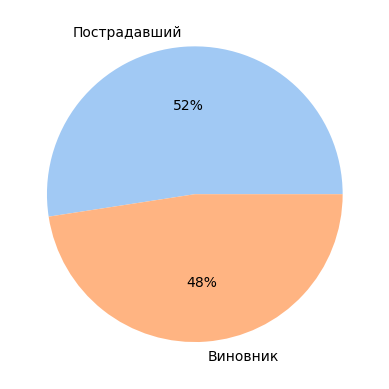

In [431]:
# баланс целевого признака
data = [df['at_fault'].value_counts()[0], df['at_fault'].value_counts()[1]]
labels = ['Пострадавший', 'Виновник']

colors = sns.color_palette('pastel')[ 0:5 ]

plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

- Пропуски отсутствуют.
- Баланс целевого признака хороший, 52% и 48%

### insurance_premium - сумма страховки

In [432]:
# статистика
f_isna('insurance_premium')
f_corr('insurance_premium')
f_phik('insurance_premium')

Количество пропусков в столбце insurance_premium: 0.78%
Линейная связь с целевым признаком: -0.12657700352827392
interval columns not set, guessing: ['at_fault', 'insurance_premium']
Phik: 0.26655673497640947


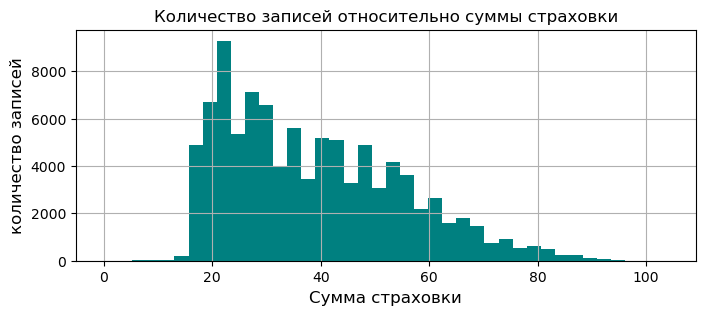

In [433]:
# визуализация количества записей относительно суммы страховки
plt.figure(figsize=(8,3))
plt.hist(df['insurance_premium'], bins=40, color='teal')
plt.grid(True)
plt.title('Количество записей относительно суммы страховки')
plt.xlabel('Сумма страховки', fontsize=12)
plt.ylabel('количество записей', fontsize=12)

plt.show()

В случае отсутствия данных в данном признаке, мы заменим пропуски на значение 0, поскольку это может указывать на отсутствие страховки у соответствующего участника.

In [434]:
df['insurance_premium'] = df['insurance_premium'].fillna(0)

In [435]:
# обновленная статистика
f_isna('insurance_premium')
f_corr('insurance_premium')
f_phik('insurance_premium')

Количество пропусков в столбце insurance_premium: 0.00%
Линейная связь с целевым признаком: -0.13423239526839287
interval columns not set, guessing: ['at_fault', 'insurance_premium']
Phik: 0.2738341854198687


- Пропуски заполнены.
- После заполнения пропусков, связь данного признака с целевым усилился.

### cellphone_in_use -  наличие телефона в автомобиле

In [436]:
# статистика
f_isna('cellphone_in_use')
f_corr('cellphone_in_use')
f_phik('cellphone_in_use')

Количество пропусков в столбце cellphone_in_use: 9.34%
Линейная связь с целевым признаком: 0.01418019212337493
interval columns not set, guessing: ['at_fault', 'cellphone_in_use']
Phik: 0.021504475537408408


- Связь данного признака с целевым переменным является слабой.
- Следует учесть, что в настоящее время большинство людей используют смартфоны, что делает данный признак менее актуальным для исследования. Рекомендуется исключить данный признак из анализа и построения моделей.

In [437]:
df = df.drop('cellphone_in_use', axis=1)

- Данный признак не имеет репрезентативной силы.
- Было принято решение исключить данный признак из дальнейшего анализа.

#### vehicle_age - возраст автомобиля (в годах)

In [438]:
# пропуски
f_isna('vehicle_age')

Количество пропусков в столбце vehicle_age: 2.50%


Данные о возрасте автомобилей невозможно восстановить на основе остальных данных, то разумным решением будет исключить записи с пропущенными значениями возраста из анализа.

In [439]:
# обработка пропусков
df = df.dropna(subset=['vehicle_age']).copy()

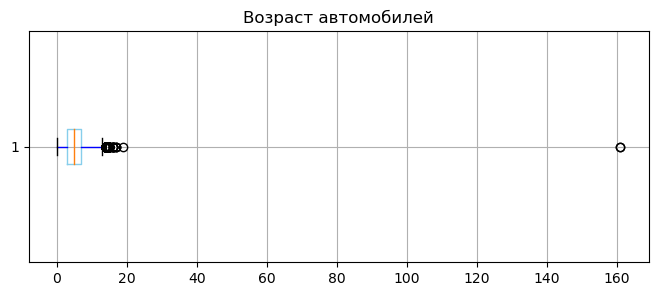

In [440]:
# boxplot для признака vehicle_age
plt.figure(figsize=(8,3))
plt.boxplot(df['vehicle_age'], vert=False, boxprops=dict(color='skyblue'), whiskerprops=dict(color='blue'))
plt.grid(True)
plt.title('Возраст автомобилей')
plt.show()

Рекомендуется ограничить максимальный возраст автомобилей, исходя из значений 25-го и 75-го квантилей, чтобы исключить аномальные значения.

In [441]:
# рассчет порога аномальных значений
q1 = df['vehicle_age'].quantile(0.25)
q3 = df['vehicle_age'].quantile(0.75)
print(f'Порог аномальных значений: {int(q3+2.5*(q3-q1))} лет')

Порог аномальных значений: 17 лет


In [442]:
df = df[df['vehicle_age']<=(q3+2.5*(q3-q1))]

In [443]:
# обновленная статистика
f_corr('vehicle_age')
f_phik('vehicle_age')

Линейная связь с целевым признаком: -0.09687363531102337
interval columns not set, guessing: ['at_fault', 'vehicle_age']
Phik: 0.22307408419985225


- Обработаны пропуски и аномальные значения.
- Присутствует связь данного признака с целевым.

### distance - расстояние от главной дороги

In [444]:
# статистика
f_isna('distance')
f_corr('distance')
f_phik('distance')

Количество пропусков в столбце distance: 0.00%
Линейная связь с целевым признаком: 0.04048321671376502
interval columns not set, guessing: ['at_fault', 'distance']
Phik: 0.0008939222252192158


Связь данного признака с целевым переменным является слабой. Рекомендуется исключить данный признак из анализа и построения моделей.

In [445]:
df = df.drop('distance', axis=1).copy()

- Данный признак не имеет репрезентативной силы.
- Было принято решение исключить данный признак из дальнейшего анализа.

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

## Анализ и обработка категориальные признаков
    
</div>

In [446]:
# общая информация 
display(df.describe(include=[object]).T)

,count,unique,top,freq
party_sobriety,93190,6,had not been drinking,84819
party_drug_physical,3733,5,G,1469
vehicle_type,94542,3,coupe,48307
vehicle_transmission,93210,2,auto,48115
county_location,94542,58,los angeles,29037
direction,70171,4,north,19431
weather_1,94304,7,clear,75361
location_type,40675,3,highway,33267
road_surface,93869,4,dry,84013
road_condition_1,94095,8,normal,91191


### party_sobriety;  party_drug_physical

__`party_sobriety`__ - трезвость участника, содержит значения:
- A — Had Not Been Drinking (Не пил)
- B — Had Been Drinking, Under Influence (Был пьян, под влиянием)
- C — Had Been Drinking, Not Under Influence (Был пьян, не под влиянием)
- D — Had Been Drinking, Impairment Unknown (Был пьян, ухудшение неизвестно)
- G — Impairment Unknown (Неизвестно ухудшение)
- H — Not Applicable (Не оценивался)
- — Not Stated (Не указано)

Данный признак содержит различные градации трезвости, оставим только 4 основных, сгруппированных по стапени воздействия:
- 0 - Had Not Been Drinking, Impairment Unknown, Not Applicable, Not Stated
- 1 - Had Been Drinking, Not Under Influence
- 2 - Had Been Drinking, Impairment Unknown
- 3 - Had Been Drinking, Under Influence

__`party_drug_physical`__ - состояние участника: физическое или с учётом принятых лекарств, значения:
- E — Under Drug Influence (Под воздействием лекарств)
- F — Impairment — Physical (Ухудшение состояния)
- G — Impairment Unknown (Не известно)
- H — Not Applicable (Не оценивался)
- I — Sleepy/Fatigued (Сонный/Усталый)
- — Not Stated (Не указано)

Здеси оставим только 2 категории (стабильное и измененное):
- 0 - Impairment Unknown, Not Applicable, Not Stated
- 1 - Under Drug Influence, Impairment — Physical, Sleepy/Fatigued

__`party_sobriety`__

In [447]:
# статистика
f_isna('party_sobriety')
f_phik('party_sobriety')

Количество пропусков в столбце party_sobriety: 1.43%
interval columns not set, guessing: ['at_fault']
Phik: 0.3814715061218021


In [448]:
# заполнение пропусков
df['party_sobriety'] = df['party_sobriety'].fillna(0)

# измененеие значений
def replace_sobriety(x):
    if x in ['had not been drinking', 'impairment unknown', 'not applicable']: return 0
    elif x == 'had been drinking, not under influence': return 1
    elif x == 'had been drinking, impairment unknown' : return 2
    else: return 3

df['party_sobriety'] = df['party_sobriety'].apply(replace_sobriety)

In [449]:
# обновленные значения
df['party_sobriety'].unique()

array([0, 3, 2, 1])

In [450]:
# обновленная статистика
f_isna('party_sobriety')
f_phik('party_sobriety')

Количество пропусков в столбце party_sobriety: 0.00%
interval columns not set, guessing: ['at_fault', 'party_sobriety']
Phik: 0.3860416731427207


In [451]:
# распределение значений
df['party_sobriety'].value_counts()

0    86814
3     6686
1      746
2      296
Name: party_sobriety, dtype: int64

- Пропуски заподнены.
- После объединения в более крупные группы, связь данного признака с целевым усилилась.
- Так же, стоит отметить, что в большинстве случает, при наличии акогольного апьянения, водители были под дополнительным воздействием других веществ.

__party_drug_physical__

In [452]:
# статистика
f_isna('party_drug_physical')
f_phik('party_drug_physical')

Количество пропусков в столбце party_drug_physical: 96.05%
interval columns not set, guessing: ['at_fault']
Phik: 0.4007735391390957


In [453]:
# заполнение пропусков
df['party_drug_physical'] = df['party_drug_physical'].fillna(0)

In [454]:
# обновленная статистика
f_isna('party_drug_physical')
f_phik('party_drug_physical')

Количество пропусков в столбце party_drug_physical: 0.00%
interval columns not set, guessing: ['at_fault']
Phik: 0.22026624635276512


In [455]:
# измененеие значений
def replace_drug_physical(x):
    if x in ['under drug influence', 'sleepy/fatigued', 'impairment - physical']: return 1
    else: return 0
    
df['party_drug_physical'] = df['party_drug_physical'].apply(replace_drug_physical)

In [456]:
# обновленная статистика
f_phik('party_drug_physical')

interval columns not set, guessing: ['at_fault', 'party_drug_physical']
Phik: 0.20662130377697624


- Пропуски заполнены, но при этом ужудшилась связь между данным признакои и целевым, что связано с большим количеством пропусков в данных.

### vehicle_type - тип кузова

In [457]:
# статистика
f_isna('vehicle_type')
f_phik('vehicle_type')

Количество пропусков в столбце vehicle_type: 0.00%
interval columns not set, guessing: ['at_fault']
Phik: 0.011231667761568932


Связь данного признака с целевым переменным является слабой. Рекомендуется исключить данный признак из анализа и построения моделей.

In [458]:
df = df.drop('vehicle_type', axis=1).copy()

- Данный признак не имеет репрезентативной силы.
- Было принято решение исключить данный признак из дальнейшего анализа.

### vehicle_transmission - тип КПП

In [459]:
# статистика
f_isna('vehicle_transmission')
f_phik('vehicle_transmission')

Количество пропусков в столбце vehicle_transmission: 1.41%
interval columns not set, guessing: ['at_fault']
Phik: 0.12940927995913806


Связь с целевым признаком можно объяснить, тем, что автоматическая коробка передач позволяет более быстро реагировать в случае аварии. восстановоть данные о КПП восстановить из данных датафрейма невозможно, а так же этот признак доступен при аренде автомобиля, исходя из этого пропуски в данном признаке, подлежат удалению.

In [460]:
df = df.dropna(subset=['vehicle_transmission']).copy()

###  county_location - названия географических районов

In [461]:
# статистика
f_isna('county_location')
f_phik('county_location')

Количество пропусков в столбце county_location: 0.00%
interval columns not set, guessing: ['at_fault']
Phik: 0.14173097598925813


In [462]:
# уникальные значения
df['county_location'].unique()

array(['kern', 'sacramento', 'los angeles', 'san joaquin',
       'san bernardino', 'alameda', 'orange', 'merced', 'santa barbara',
       'san francisco', 'solano', 'san diego', 'fresno', 'contra costa',
       'santa clara', 'tulare', 'riverside', 'sutter', 'ventura',
       'imperial', 'san mateo', 'el dorado', 'lassen', 'mendocino',
       'sonoma', 'humboldt', 'calaveras', 'san luis obispo', 'inyo',
       'shasta', 'monterey', 'modoc', 'amador', 'stanislaus', 'marin',
       'placer', 'glenn', 'lake', 'colusa', 'kings', 'butte', 'yuba',
       'madera', 'yolo', 'tehama', 'tuolumne', 'nevada', 'santa cruz',
       'del norte', 'napa', 'trinity', 'siskiyou', 'sierra', 'san benito',
       'mono', 'mariposa', 'plumas', 'alpine'], dtype=object)

Есть связь между данным признаким и целевым, но большое количество уникальных значений, может затруднить обучение моделей, сгруппируем районы по составляющим агломерациям:

In [463]:
agglomerations = {
    'Southern California': ['los angeles', 'ventura', 'orange', 'riverside', 'san bernardino'],
    'San Francisco Bay Area': ['san francisco', 'santa clara', 'alameda', 'contra costa', 'san mateo', 'marin'],
    'Central Valley': ['san joaquin', 'merced', 'tulare', 'fresno', 'kern', 'stanislaus'],
    'Sacramento Metropolitan Area': ['sacramento', 'placer', 'el dorado'],
    'Central Coast': ['santa cruz', 'monterey', 'san luis obispo', 'santa barbara', 'ventura'],
    'North Coast': ['napa', 'sonoma', 'mendocino', 'humboldt'],
    'Inland Empire': ['riverside', 'san bernardino'],
    'San Diego Metropolitan Area': ['san diego'],
    'Sierra Nevada': ['nevada', 'calaveras', 'madera', 'tuolumne', 'amador', 'tehama', 'glenn', 'mariposa', 'sierra', 'plumas', 'trinity', 'lassen', 'plumas', 'trinity', 'sierra', 'modoc'],
    'Northern California': ['butte', 'sutter', 'yolo', 'lake', 'yuba', 'yolo', 'inyo', 'mono', 'yuba'],
    'Far Northern California': ['del norte', 'humoldt', 'siskiyou', 'alpine', 'colusa']
}
# функция для замены
def county_to_agglomeration(county):
    for agglomeration, counties in agglomerations.items():
        if county.lower() in [c.lower() for c in counties]:
            return agglomeration
    return county

# применяем функцию к столбцу 'county_location'
df['county_location'] = df['county_location'].map(county_to_agglomeration)

In [464]:
# количество уникальных значений
len(df['county_location'].unique())

15

In [465]:
# обновленнная статистика
f_isna('county_location')
f_phik('county_location')

Количество пропусков в столбце county_location: 0.00%
interval columns not set, guessing: ['at_fault']
Phik: 0.1031010847053475


- Мы снизили количество уникальных значений, с 58 до 15.
- Незначительно ослабела связь с целевым признаком

### direction - направление движения

In [466]:
# статистика
f_isna('direction')
f_phik('direction')

Количество пропусков в столбце direction: 25.57%
interval columns not set, guessing: ['at_fault']
Phik: 0.0


Данный признак, не связан с целевым, и может быть исключен из анализа.

In [467]:
df = df.drop('direction', axis=1).copy()

### weather_1 - погода

In [468]:
# статистика
f_isna('weather_1')
f_phik('weather_1')

Количество пропусков в столбце weather_1: 0.25%
interval columns not set, guessing: ['at_fault']
Phik: 0.04587133715766151


In [469]:
# уникальные значения
df['weather_1'].unique()

array(['clear', 'raining', 'cloudy', 'snowing', 'fog', None, 'other',
       'wind'], dtype=object)

Признак слабо связан с целевым, и большенство аварий происходят в ясную погоду (п. Анализ зависимости вероятности возникновения ДТП от погодных условий.)

Данный признакразделим на две группы:
0 - 'clear' и пропуски;
1 - другие погодные условия

In [470]:
# обработка пропусков
df['weather_1'] = df['weather_1'].fillna(0)

In [471]:
# замена значений
df['weather_1'] = df['weather_1'].apply(lambda x: 0 if x=='clear' else 1)

In [472]:
# обновленная статистика 
f_isna('weather_1')
f_phik('weather_1')

Количество пропусков в столбце weather_1: 0.00%
interval columns not set, guessing: ['at_fault', 'weather_1']
Phik: 0.0660556008306189


- Пропуски заполнены.
- Связь с целевым признаком усилилась.

### location_type - тип дороги

In [473]:
# статистика 
f_isna('location_type')
f_phik('location_type')

Количество пропусков в столбце location_type: 56.66%
interval columns not set, guessing: ['at_fault']
Phik: 0.014335733458780064


Данный признак, слабо связан с целевым, и может быть исключен из анализа.

In [474]:
df = df.drop('location_type', axis=1).copy()

### road_surface - cостояние дороги

In [475]:
# статистика 
f_isna('road_surface')
f_phik('road_surface')

Количество пропусков в столбце road_surface: 0.70%
interval columns not set, guessing: ['at_fault']
Phik: 0.10405873090105269


- Данный признак связан с целевым.
- Пропуски заменим на 0.
- Значения разделим на две группы:
   - 0 - 'dry' дорога чистая, либо данных нет.
   - 1 - на дороге присутствуют факторы которые могут повлечь затруднение движения.

In [476]:
# обработка пропусков
df['road_surface'] = df['road_surface'].fillna(0)

In [477]:
# замена значений
df['road_surface'] = df['road_surface'].apply(lambda x: 0 if x=='dry' else 1)

In [478]:
# обновленная статистика 
f_isna('road_surface')
f_phik('road_surface')

Количество пропусков в столбце road_surface: 0.00%
interval columns not set, guessing: ['at_fault', 'road_surface']
Phik: 0.09426680260359567


- Пропуски заполнены.
- После замены значений, связь с целевым признаком изменилась незначительно.

### lighting - освещение

In [479]:
# статистика 
f_isna('lighting')
f_phik('lighting')

Количество пропусков в столбце lighting: 0.28%
interval columns not set, guessing: ['at_fault']
Phik: 0.08655921460131097


- Данный признак связан с целевым.
- Пропуски заменим на 0.
- Значения разделим на две группы:
   - 0 - 'daylight', 'dark with street lights', данных нет - дорога освещенная.
   - 1 - присутствуют факторы затрудняющии обзор.

In [480]:
# обработка пропусков
df['lighting'] = df['lighting'].fillna(0)

In [481]:
# замена значений
df['lighting'] = df['lighting'].apply(lambda x: 0 if x in ['daylight', 'dark with street lights'] else 1)

In [482]:
# обновленная статистика 
f_isna('lighting')
f_phik('lighting')

Количество пропусков в столбце lighting: 0.00%
interval columns not set, guessing: ['at_fault', 'lighting']
Phik: 0.12384536706849826


- Пропуски заполнены.
- После замены значений, связь с целевым признаком усилилась.

### control_device - работоспособность устройств управления

In [483]:
# статистика 
f_isna('control_device')
f_phik('control_device')

Количество пропусков в столбце control_device: 0.41%
interval columns not set, guessing: ['at_fault']
Phik: 0.13762197743801882


- Заменим пропуски и значение 'none' на 'no_info'

In [484]:
# обработка пропусков
df['control_device'] = df['control_device'].fillna('no_info')
# замена значений
df['control_device'] = df['control_device'].apply(lambda x: 'no_info' if x=='none' else x)

In [485]:
# статистика 
f_isna('control_device')
f_phik('control_device')

Количество пропусков в столбце control_device: 0.00%
interval columns not set, guessing: ['at_fault']
Phik: 0.13740604313506957


- Обработаны пропуски.
- Призк имеет связь с целевым.

### collision_time - время происшествия

Обединим признак в категории:
- Утро
- День
- Вечер
- Ночь

In [486]:
# количество пропусков
f_isna('collision_time')

Количество пропусков в столбце collision_time: 0.11%


Восстановить данные о времени восстановить или найти логичную замену по остальным данным нет возможносни, будет логично их удалить

In [487]:
df = df.dropna(subset=['collision_time']).copy()

In [488]:
# преобразуем столбец 'collision_time' в формат времени
df['collision_time'] = pd.to_datetime(df['collision_time'], format='%H:%M:%S')

In [489]:
# округляем часы до ближайшего значения
df['collision_time'] = df['collision_time'].dt.round('H').dt.hour

In [490]:
# функция для определения категории времени
def get_time_category(hour):
    if 0 <= hour < 6:
        return 'Ночь'
    elif 6 <= hour < 12:
        return 'Утро'
    elif 12 <= hour < 18:
        return 'День'
    else:
        return 'Вечер'

df['collision_time'] = df['collision_time'].apply(get_time_category)

In [491]:
# обновленная статистика 
f_isna('collision_time')
f_phik('collision_time')

Количество пропусков в столбце collision_time: 0.00%
interval columns not set, guessing: ['at_fault']
Phik: 0.21506244563882612


- Пропуски обработаны.
- Время переведено в категирии.
- Присутствует связь между данным признаком и целевым

### collision_date - дата происшествия

In [492]:
# количество пропусков
f_isna('collision_date')

Количество пропусков в столбце collision_date: 0.00%


In [493]:
# преобразование столбца 'collision_date' в формат даты
df['collision_date'] = pd.to_datetime(df['collision_date'])
# извлечение номера месяца
df['collision_date'] = df['collision_date'].dt.month

In [494]:
f_phik('collision_date')

interval columns not set, guessing: ['at_fault', 'collision_date']
Phik: 0.04974468892392562


In [495]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Зима'
    elif month in [3, 4, 5]:
        return 'Весна'
    elif month in [6, 7, 8]:
        return 'Лето'
    else:
        return 'Осень'
    
df['collision_date'] = df['collision_date'].apply(get_season)

In [496]:
f_phik('collision_date')

interval columns not set, guessing: ['at_fault']
Phik: 0.0471014682904708


- Пропуски отсутствуют.
- Связь  с целевым признакомпосле пребразования в сезоны года изменилась не сильно, но осталась достаточно слабой

### road_condition_1 -  дорожное состояние

In [497]:
# статистика 
f_isna('road_condition_1')
f_phik('road_condition_1')

Количество пропусков в столбце road_condition_1: 0.46%
interval columns not set, guessing: ['at_fault']
Phik: 0.04208034379410317


Данный признак, слабо связан с целевым, и может быть исключен из анализа.

In [498]:
df = df.drop('road_condition_1', axis=1).copy()

### Итоговый датасет

In [499]:
display(df.head())

,index,at_fault,insurance_premium,party_sobriety,party_drug_physical,vehicle_transmission,vehicle_age,county_location,weather_1,road_surface,lighting,control_device,collision_date,collision_time
0,0,1,30.0,0,0,auto,1.0,Central Valley,0,0,1,no_info,Весна,Ночь
1,1,1,25.0,0,0,auto,0.0,Sacramento Metropolitan Area,1,1,0,no_info,Весна,Утро
2,2,1,72.0,0,0,auto,6.0,Southern California,0,0,0,no_info,Зима,Утро
3,3,1,19.0,0,0,manual,2.0,Southern California,0,0,0,functioning,Зима,Вечер
4,4,1,60.0,0,0,auto,9.0,Central Valley,0,0,0,no_info,Зима,День


In [500]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93111 entries, 0 to 96965
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 93111 non-null  int64  
 1   at_fault              93111 non-null  int64  
 2   insurance_premium     93111 non-null  float64
 3   party_sobriety        93111 non-null  int64  
 4   party_drug_physical   93111 non-null  int64  
 5   vehicle_transmission  93111 non-null  object 
 6   vehicle_age           93111 non-null  float64
 7   county_location       93111 non-null  object 
 8   weather_1             93111 non-null  int64  
 9   road_surface          93111 non-null  int64  
 10  lighting              93111 non-null  int64  
 11  control_device        93111 non-null  object 
 12  collision_date        93111 non-null  object 
 13  collision_time        93111 non-null  object 
dtypes: float64(2), int64(7), object(5)
memory usage: 10.7+ MB


None

<div style="padding: 30px 25px; border: 2px #6495ed solid">

- Обработаты пропуски.
- Отобраны наиболее значимые признаки
- Проведена проверка и исключены аномалии.

</div>

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Разработка моделей
    
</div>

__Проведем сравнительный анализ трех моделей, обученных на следующих алгоритмах:__
- LogisticRegression
- CatBoost
- Нейросеть на основе фреймворка PyTorch
     
__Метрики качества для оценки модели:__

- accuracy — точность. Основная проблема этой метрики — это несбалансированные выборки. При дисбалансе классов(особенно, если дисбаланс существенный), accuracy не показательна, так как результат может быть искажен из-за того, что модель лучше предсказывает больший класс. Так как, в нашем случае оба класса целевой переменной представлены поровну, сбалансированы, данная метрика является репризентативной.
- precision -  показывает, какая доля объектов, которую модель определила как положительные, действительно положительные. То есть, максимизируя метрику precision, мы пытаемся минимизировать количество ложноположительных ответов: клиентов, которые могут попасть в аварию, при аренде автомобилей.
- __recall__ — это доля положительных объектов, которую нашла модель, из всех положительных объектов. Максимизируя recall мы хотим минимизировать количество ложноотрицательных ответов модели: клиентов, которые попали в аварию, хотя модель определила, что не попадут. Исходя из задачи, эта метрика является основной для выбора лучшей модели.

## Выделение обучающей и тестовой выборок

In [610]:
# категориальные признаки
categorical_columns = ['party_drug_physical', 'vehicle_transmission', 'county_location',
                       'weather_1', 'road_surface', 'lighting', 'collision_time',
                       'collision_date', 'control_device']

# числовые признаки
numeric_columns = ['insurance_premium', 'vehicle_age', 'party_sobriety']


# признаки
X = df[categorical_columns + numeric_columns]
# целевой признак
y = df['at_fault']

In [611]:
# формирование выборок с сохранением баланса классов
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=RANDOM_SEED)

In [612]:
# проверка баланса классов в выборках
print(f'''Баланс классов целевого признака:
y_train:
{round(y_train.value_counts()/len(y_train)*100)}
y_test:
{round(y_test.value_counts()/len(y_test)*100)}
''')


Баланс классов целевого признака:
y_train:
0    53.0
1    47.0
Name: at_fault, dtype: float64
y_test:
0    53.0
1    47.0
Name: at_fault, dtype: float64



- Выделены обучающая и тестовая выборки.
- Баланс классов в выборках сохранен.

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

## LogisticRegression
    
</div>

Для обучения данной модели необходима предварительная обработка данных:
- OneHotEncoder для категориальных признаков
- Масштабированые числовых признаков

In [613]:
# преобразование входных данных
col_transformer_ohe = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        categorical_columns
    ),
    (
        StandardScaler(),
        numeric_columns
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

# метрики качества
scorer = ['accuracy', 'precision', 'recall']

# параметры кросс-валидации
cv = StratifiedKFold(n_splits = SPLITS, shuffle = True, random_state = RANDOM_SEED)

# экземпляр модели
LogReg = LogisticRegression(n_jobs=-1)

# Pipeline обучения модели
model_log_reg = Pipeline([('transformer', col_transformer_ohe), ('classifier', LogReg)])

# подбираемые гиперпараметры
parameters = {
    'classifier__C': [0.0001, 0.001, 0.01, 10, 0.0005],
    'classifier__solver': ['saga', 'sag', 'newton-cg']
}

# параметры для обучения с подбором гиперпараметров
grid_cv_lr = GridSearchCV(model_log_reg, parameters, scoring=scorer, cv=cv, n_jobs=-1, refit='accuracy')

In [614]:
# обучение и подбор оптимальных параметров
grid_cv_lr.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['party_drug_physical',
                                                                          'vehicle_transmission',
                                                                          'county_location',
                                                                          'weather_1',
                                                                          'road_surface',
                                                                          'lighting',
                                                                          'collisio...
                                                                          'control_device']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['insurance_premium',
                                                                          'vehicle_age',
                                                                          'party_sobriety'])],
                                                          verbose_feature_names_out=False)),
                                       ('classifier',
                                        LogisticRegression(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.0001, 0.001, 0.01, 10, 0.0005],
                         'classifier__solver': ['saga', 'sag', 'newton-cg']},
             refit='accuracy', scoring=['accuracy', 'precision', 'recall'])

In [615]:
# результаты обучения
result = grid_cv_lr.cv_results_ 
best_params_lr = grid_cv_lr.best_params_
precision_lr = result['mean_test_precision'][np.argmin(result['rank_test_precision'])]
recall_lr = result['mean_test_recall'][np.argmin(result['rank_test_recall'])]
accuracy_lr = grid_cv_lr.best_score_
# вывод результатов
print(f'''Оптимальные гиперпараметры LogisticRegression:
{best_params_lr}
Accuracy: {round(accuracy_lr, 2)}
Precision: {round(precision_lr, 2)}
Recall: {round(recall_lr, 2)}''')

Оптимальные гиперпараметры LogisticRegression:
{'classifier__C': 0.001, 'classifier__solver': 'sag'}
Accuracy: 0.63
Precision: 0.76
Recall: 0.42


- Успешно подобраны гиперпараметры для модели на основе LogisticRegression.
- Метрики качества модели, на выборке для обучения, при кроссвалидации:
    - Accuracy: 0.63
    - Precision: 0.76
    - Recall: 0.42

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

## CatBoost
    
</div>

- Для модели СatBoost не требуется масштабирование числовых признаков, и кодирования категориальных, так так данный алгоритм имеет встреенные, более совершенные методы.
- Для подбора гиперпараметров, оспользуем библиотеку optuna.
- Так же для кросс-валидации используем KFold для выделения подвыборок.

In [605]:
# определение количества подвыборок
cv_kfold = KFold(n_splits=SPLITS, random_state=RANDOM_SEED, shuffle=True)
# гиперпараметры optuna
def objective(trial):
    model = CatBoostClassifier(
        iterations=1000,
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli"]),
        random_state = RANDOM_SEED,
        verbose=False
    )
    scors = 0
    for train_fold_index, val_fold_index in cv_kfold.split(X_train):
        features_train_fold, target_train_fold = X_train.iloc[train_fold_index], y_train.iloc[train_fold_index]
        features_val_fold, target_val_fold = X_train.iloc[val_fold_index], y_train.iloc[val_fold_index]
        
        # train pool
        train = Pool(data=features_train_fold,
                     label=target_train_fold,
                     cat_features=categorical_columns
                     )
        # validation pool
        valid = Pool(data=features_val_fold,
                     cat_features=categorical_columns
                     )
        # обучение модели с текущими гиперпараметрами
        model.fit(train)
        # предсказание
        pred = model.predict(valid)
        score = accuracy_score(target_val_fold, pred)
        scors += score
    return scors/SPLITS

In [606]:
# параметры подбора параметров
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(study_name="catboost", direction="maximize")
study.optimize(objective, n_trials=50)

In [607]:
# вывод результатов 
print("Результаты подборы параметров:")
trial = study.best_trial
print("  Accuracy: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Результаты подборы параметров:
  Accuracy:  0.6460699479738173
  Params: 
    learning_rate: 0.017264554033147615
    depth: 5
    l2_leaf_reg: 99.08918240933248
    bootstrap_type: Bernoulli


## CatBoost модель с лучшими гиперпараметрами

In [608]:
# модель с оптимальными параметрами
model_cb = CatBoostClassifier(**trial.params, verbose=False, random_state=RANDOM_SEED)

In [609]:
accuracy_cb = 0
precision_cb = 0
recall_cb = 0
for train_fold_index, val_fold_index in cv_kfold.split(X_train):
    features_train_fold, target_train_fold = X_train.iloc[train_fold_index], y_train.iloc[train_fold_index]
    features_val_fold, target_val_fold = X_train.iloc[val_fold_index], y_train.iloc[val_fold_index]
        
    # train pool
    train = Pool(data=features_train_fold,
                 label=target_train_fold,
                 cat_features=categorical_columns
                 )
    # validation pool
    valid = Pool(data=features_val_fold,
                 cat_features=categorical_columns
                )
    # обучение модели
    model_cb.fit(train)
    # предсказание
    pred = model_cb.predict(valid)
    
    accuracy_cb += accuracy_score(target_val_fold, pred)
    precision_cb += precision_score(target_val_fold, pred)
    recall_cb += recall_score(target_val_fold, pred, average='binary')
# финальные метрики
accuracy_cb /= SPLITS
precision_cb /= SPLITS
recall_cb /= SPLITS
# вывод результатов
print(f'''Метрики CatBoost:
Accuracy: {round(accuracy_cb, 2)}
Precision: {round(precision_cb, 2)}
Recall: {round(recall_cb, 2)}''')

Метрики CatBoost:
Accuracy: 0.65
Precision: 0.69
Recall: 0.47


In [ ]:
# обучение модели на всех тренировочных данных

# train pool
train = Pool(data=X_train,
             label=y_train,
             cat_features=categorical_columns
             )
# итоговая модель CatBoost
model_cb.fit(train)

- Успешно подобраны гиперпараметры для модели на основе CatBoost.
- Метрики качества модели, на выборке для обучения, при кроссвалидации:
    - Accuracy: 0.65
    - Precision: 0.69
    - Recall: 0.49

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

## Нейросеть PyTorch
</div>

Для обучения данной модели необходима предварительная обработка данных:
- OneHotEncoder для категориальных признаков
- Масштабированые числовых признаков

### Подготовка данных

In [773]:
# маштабирование входных данных
X_train_transform = col_transformer_ohe.fit_transform(X_train)
X_test_transform = col_transformer_ohe.transform(X_test)
# преобразование разреженной матрицы в массив NumPy
X_train_array = X_train_transform.toarray()
X_test_array = X_test_transform.toarray()
# преобразование матриц в тензоры
X_train_tensor = torch.from_numpy(X_train_array).to(torch.float32)
X_test_tensor = torch.from_numpy(X_test_array).to(torch.float32)
y_train_tensor = torch.Tensor(y_train.values)
y_test_tensor = torch.Tensor(y_test.values)
# проверка размерности и типа данных тензоров
for x in ['X_train_tensor', 'X_test_tensor', 'y_train_tensor', 'y_test_tensor']:
    print(f'Размерность {x}: {globals()[x].shape} - {globals()[x].dtype}')

Размерность X_train_tensor: torch.Size([69833, 31]) - torch.float32
Размерность X_test_tensor: torch.Size([23278, 31]) - torch.float32
Размерность y_train_tensor: torch.Size([69833]) - torch.float32
Размерность y_test_tensor: torch.Size([23278]) - torch.float32


- Для создания пакетов (batch) используем Dataloader, предоставляющий удобный способ загрузки и предварительной обработки данных во время обучения моделей машинного обучения. Данный компонент PyTorch позволяет настраивать различные параметры для загрузки данных, такие как размер пакета (batch size), количество рабочих процессов для параллельной загрузки данных (num_workers), случайное перемешивание данных (shuffle) 

In [693]:
# класс для создания пакетов обучения
class Batch(Dataset):
  def __init__(self, data, labels):
    self.labels = labels
    self.data = data

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    label = self.labels[idx]
    data = self.data[idx]
    sample = {'data': data, 'at_fault': label}
    return sample

In [694]:
# DataLoader выборки
dataset_train = Batch(X_train_tensor, y_train_tensor)
dataset_test = Batch(X_test_tensor, y_test_tensor)

### Архитектура нейронной сети

1 Входной слой:

   - Размерность входных данных определяется переменной input_size и равен количеству признаков.
   - Этот слой представлен в виде линейного слоя (nn.Linear), который принимает входные данные и производит линейную трансформацию с помощью весов и смещения.
   
2 Скрытые слои:

   - В данной архитектуре нейронной сети используем четыре скрытых слоя.
   - Каждый скрытый слой состоит из линейного слоя (nn.Linear), за которым следует функция активации.
   - Функции активации, используемые в этой архитектуре, определяются переменными activation_1, activation_2, activation_3, activation_4.
   - Добавление техники регуляризации Dropout, поможет улучшить обобщающую способность нейронной сети и снизит риск переобучения, вероятности выключения нейронов в слоях определяются переменными drop_1, drop_2, drop_3, drop_4. В baseline-модели данную технику применим только к первому слою, затем подберем оптимальные параметры для этого и остальных слоев.
   - Размеры скрытого слоя определяются переменными hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4.
   
3 Выходной слой:

   - Выходной слой представлен линейным слоем (nn.Linear), который преобразует выходные значения скрытых слоев в одно значение.
   - В данном случае, поскольку решается задача бинарной классификации, выходной слой имеет размерность 1 и задается переменной output_size.
   
4 Инициализация весов:
   - Инициализацию весов будем производить с помощью метода Kaiming, что может помочь ускорить процесс обучения и предотвратить затухания/взрыва градиента.

In [716]:
# определение архитектуры нейронной сети
class Baseline(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, output_size,
                 drop_1, drop_2, drop_3, drop_4,
                 activation_1, activation_2, activation_3, activation_4):
        super(Baseline, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.act1 = activation_1
        self.drop1 = nn.Dropout(drop_1)
        
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.act2 = activation_2
        self.drop2 = nn.Dropout(drop_2)
        
        self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.act3 = activation_3
        self.drop3 = nn.Dropout(drop_3)
        
        self.fc4 = nn.Linear(hidden_size_3, hidden_size_4)
        self.act4 = activation_4
        self.drop4 = nn.Dropout(drop_4)
        
        self.fc5 = nn.Linear(hidden_size_4, output_size)
        
        self.init_weights()
        
    def forward(self, x):
        x = self.drop1(self.act1(self.fc1(x)))
        x = self.drop2(self.act2(self.fc2(x)))
        x = self.drop3(self.act3(self.fc3(x)))
        x = self.drop4(self.act4(self.fc4(x)))
        x = self.fc5(x)
        return x
    
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal_(m.weight)
            m.bias.data.fill_(0.01)

#### Ранняя остановка

Чтобы не подбирать коливо эпох и при этом избежать переобучения, воспользуемся ранней остановкой, для этого напишем класс для ее реализации.

In [717]:
class CustomEarlyStopping():
    """
    Ранняя остановка: остановить тренировку, если функция потерь не улучшается после определенного количества эпох.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: сколько эпох ждать, прежде чем остановиться
        :param min_delta: минимальная разница функций потерь для активации param patience
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:  # обновление значения функция потерь при улучшении
            self.best_loss = val_loss 
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:  # счетчик patience при ухудшении функция потерь
            self.counter += 1
            if self.counter >= self.patience:
                print(f'INFO: Ранняя остановка. Счетчик: {self.counter}/{self.patience}')
                self.early_stop = True  # остановка обучения при достижении максимума счетсика patience

### Baseline-модель нейронной сети

In [627]:
# параметры Baseline нейронной сети

# размер слоев
input_size = X_train_tensor.shape[1]  
hidden_size_1 = 50  
hidden_size_2 = 40  
hidden_size_3 = 5  
hidden_size_4 = 45  
output_size = 1 
# функции активации
activation_1 = nn.ReLU()
activation_2 = nn.Tanh()
activation_3 = nn.ReLU()
activation_4 = nn.LeakyReLU()
# вероятности выключения нейроны в слое
drop_1 = 0.1
drop_2 = 0.0
drop_3 = 0.0
drop_4 = 0.0

learning_rate = 0.001  # скорость обучения
n_epochs = 1000  # количество эпох обучения
batch_size = 500  # размер пакета

In [628]:
# экземпляр нейронной сети
model = Baseline(input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, output_size,
                 drop_1, drop_2, drop_3, drop_4,
                 activation_1, activation_2, activation_3, activation_4)
# функция потерь
loss = nn.BCEWithLogitsLoss()
# оптимизатор
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# пакеты (batch)
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True,
                              num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, num_workers=0)

__Функция для обучения__

In [681]:
def train(model, train_dataloader, test_dataloader, optimizer, loss, n_epochs, patience, min_delta):
    result = {'train_loss': [], 'test_loss': [], 'accuracy': [], 'precision': [], 'recall': [],
              'best_epoch': None, 'stopping_epoch': None, 'best_model': None}

    early_stopping = CustomEarlyStopping(patience, min_delta)

    for epoch in range(n_epochs):
        # обучение
        model.train()
        total_loss_train = 0.0

        for batch in train_dataloader:
            data = batch['data']
            label_train = batch['at_fault']
            label_train = label_train.unsqueeze(1)

            optimizer.zero_grad()

            predictions = model(data)
            loss_value = loss(predictions, label_train.float())  
            total_loss_train += loss_value.item()

            loss_value.backward()
            optimizer.step()

        train_loss = total_loss_train / len(train_dataloader)
        result['train_loss'].append(train_loss)

        # тестирование
        model.eval()
        total_loss_test = 0.0
        total_accuracy_test = 0.0
        total_precision_test = 0.0
        total_recall_test = 0.0
        
        with torch.no_grad():  # отключение вычисления градиентов
            for batch in test_dataloader:
                data = batch['data']
                label_test = batch['at_fault']
                label_test = label_test.unsqueeze(1)

                predictions = model(data)
                loss_value = loss(predictions, label_test.float())
                total_loss_test += loss_value.item()
                
                binary_predictions = (predictions >= 0.5).int()
                total_accuracy_test += accuracy_score(label_test, binary_predictions)
                total_precision_test += precision_score(label_test, binary_predictions, zero_division=1, average='binary')
                total_recall_test += recall_score(label_test, binary_predictions, zero_division=1, average='binary')
                
        test_loss = total_loss_test / len(test_dataloader)
        result['test_loss'].append(test_loss)
        
        result['accuracy'].append(total_accuracy_test / len(test_dataloader))
        result['precision'].append(total_precision_test / len(test_dataloader))
        result['recall'].append(total_recall_test / len(test_dataloader))

        if epoch % 10 == 0 or epoch == n_epochs - 1:
            print(f'Epoch: {epoch} Train Loss: {train_loss:.4f} Test Loss: {test_loss:.4f} Accuracy: {result["accuracy"][-1]:.2f}')

        early_stopping(test_loss)
        if early_stopping.counter == 1:
            result['best_model'] = model
        if early_stopping.early_stop:
            result['best_epoch'] = epoch - patience
            result['stopping_epoch'] = epoch
            print(f"Best epoch: {epoch - patience} Train Loss: {result['train_loss'][-patience]:.4f} Test Loss: {result['test_loss'][-patience]:.4f}")
            print(f"Accuracy: {result['accuracy'][-patience]:.2f} Precision: {result['precision'][-patience]:.2f} Recall: {result['recall'][-patience]:.2f}")
            break
        if epoch == n_epochs - 1:
            result['best_epoch'] = epoch
            result['stopping_epoch'] = epoch
            print(f"Best epoch: {epoch} Train Loss: {result['train_loss'][-1]:.4f} Test Loss: {result['test_loss'][-1]:.4f}")
            print(f"Accuracy: {result['accuracy'][-1]:.2f} Precision: {result['precision'][-1]:.2f} Recall: {result['recall'][-1]:.2f}")

    return result

In [630]:
# обучение и сохранение результатов
result = train(model=model,
               train_dataloader=train_dataloader,
               test_dataloader=test_dataloader,
               optimizer=optimizer,
               loss=loss,
               n_epochs=n_epochs,
               patience=20,
               min_delta=0)

Epoch: 0 Train Loss: 0.6501 Test Loss: 0.6218 Accuracy: 0.62
Epoch: 10 Train Loss: 0.6150 Test Loss: 0.6142 Accuracy: 0.63
Epoch: 20 Train Loss: 0.6133 Test Loss: 0.6149 Accuracy: 0.64
Epoch: 30 Train Loss: 0.6122 Test Loss: 0.6150 Accuracy: 0.63
INFO: Ранняя остановка. Счетчик: 20/20
Best epoch: 12 Train Loss: 0.6143 Test Loss: 0.6151
Accuracy: 0.63 Precision: 0.80 Recall: 0.31


- Метрики качества Baseline-модель нейронной сети:
    - Accuracy: 0.63
    - Precision: 0.80
    - Recall: 0.31

__График процесса обучения__

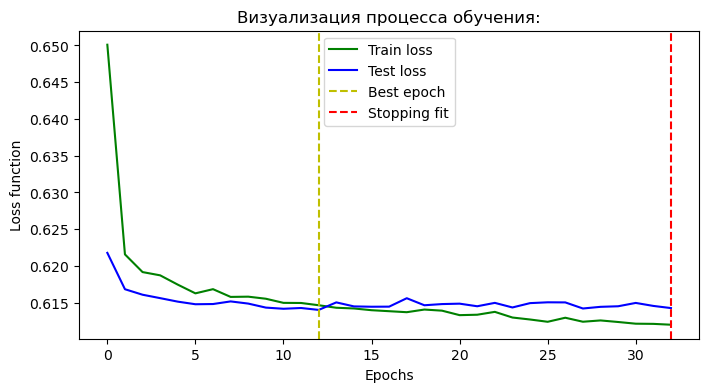

In [633]:
plt.figure(figsize=(8, 4))
plt.plot(result['train_loss'], color='green', label='Train loss')
plt.plot(result['test_loss'], color='blue', label='Test loss')

# отметка Best epoch
plt.axvline(x=result['best_epoch'], color='y', linestyle='--', label='Best epoch')
# отметка Stopping train
plt.axvline(x=result['stopping_epoch'], color='red', linestyle='--', label='Stopping fit')

plt.title('Визуализация процесса обучения:')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend(loc='best')
plt.show()

### Подбор оптимальных параметров
- Для подбора оптимальных параметров используем __optuna__

In [700]:
y_train_tensor = y_train_tensor.view(-1, 1)
# функция для подбора параметров с помощью Optuna
def objective(trial):
    
    # dropout
    drop_1 = trial.suggest_float('module__drop_1', 0.0, 0.5, step=0.1)
    drop_2 = trial.suggest_float('module__drop_2', 0.0, 0.5, step=0.1)
    drop_3 = trial.suggest_float('module__drop_3', 0.0, 0.5, step=0.1)
    drop_4 = trial.suggest_float('module__drop_4', 0.0, 0.5, step=0.1)

    # функции активации
    activation_dict = {'nn.LeakyReLU()': nn.LeakyReLU(),
                       'nn.ReLU()': nn.ReLU(),
                       'nn.Tanh()': nn.Tanh(),
                       'nn.ELU()': nn.ELU(),
                       'nn.Sigmoid()': nn.Sigmoid()
                      }

    activation_1 = trial.suggest_categorical('module__activation_1', ['nn.LeakyReLU()', 'nn.ReLU()', 'nn.Tanh()', 'nn.ELU()', 'nn.Sigmoid()'])
    activation_2 = trial.suggest_categorical('module__activation_2', ['nn.LeakyReLU()', 'nn.ReLU()', 'nn.Tanh()', 'nn.ELU()', 'nn.Sigmoid()'])
    activation_3 = trial.suggest_categorical('module__activation_3', ['nn.LeakyReLU()', 'nn.ReLU()', 'nn.Tanh()', 'nn.ELU()', 'nn.Sigmoid()'])
    activation_4 = trial.suggest_categorical('module__activation_4', ['nn.LeakyReLU()', 'nn.ReLU()', 'nn.Tanh()', 'nn.ELU()', 'nn.Sigmoid()'])

    activation_1 = activation_dict.get(activation_1)
    activation_2 = activation_dict.get(activation_2)
    activation_3 = activation_dict.get(activation_3)
    activation_4 = activation_dict.get(activation_4)

    # количество нейронов
    input_size = X_train_tensor.shape[1] 
    output_size = 1

    hidden_size_1 = trial.suggest_int('module__hidden_size_1', 5, 80, step=5)
    hidden_size_2 = trial.suggest_int('module__hidden_size_2', 5, 80, step=5)
    hidden_size_3 = trial.suggest_int('module__hidden_size_3', 5, 80, step=5)
    hidden_size_4 = trial.suggest_int('module__hidden_size_4', 5, 80, step=5)

    # скорость обучения
    lr = trial.suggest_float('learning_rate', 1e-6, 1e-2, log=True)
    
    # размер пакета обучения
    batch_size = trial.suggest_int('batch_size', 5, 1005, step=50)
    
    # модель
    model_base = Baseline(input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, output_size,
                          drop_1, drop_2, drop_3, drop_4,
                          activation_1, activation_2, activation_3, activation_4)

    # функция потерь
    loss = nn.BCEWithLogitsLoss() 

    # количество шагов до остановки обучения
    patience = trial.suggest_int('patience', 10, 60, step=5)

    # параметры подбора параметров модели
    skorch_classifier = NeuralNetClassifier(module=model_base,
                                            device='cpu',
                                            verbose=0,
                                            batch_size=batch_size,
                                            optimizer=torch.optim.Adam,
                                            max_epochs=500,
                                            lr=lr,
                                            train_split=ValidSplit(cv=4),
                                            criterion=loss,
                                            callbacks=[
                                                ('val_acc', EpochScoring(scoring='accuracy', lower_is_better=False, name='val_acc')),
                                                ('estopper', EarlyStopping(lower_is_better=True, monitor='val_acc', patience=patience))
                                            ]
                                           )

    # перекрестная проверка
    accuracy = cross_val_score(skorch_classifier, X_train_tensor.numpy().astype('float32'),
                           y_train_tensor.numpy().astype('float32'),
                           n_jobs=-1,
                           cv=4,
                           scoring='accuracy')

    return 1 - accuracy.mean()  # Optuna минимизирует целевую функцию, поэтому используем (1 - accuracy)


In [701]:
# оптимизация с помощью Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

In [703]:
# оптимальные параметры
best_params = study.best_trial.params
display('Оптимальные параметры:', best_params)

'Оптимальные параметры:'

{'module__drop_1': 0.0,
 'module__drop_2': 0.1,
 'module__drop_3': 0.0,
 'module__drop_4': 0.4,
 'module__activation_1': 'nn.LeakyReLU()',
 'module__activation_2': 'nn.ELU()',
 'module__activation_3': 'nn.Tanh()',
 'module__activation_4': 'nn.LeakyReLU()',
 'module__hidden_size_1': 55,
 'module__hidden_size_2': 15,
 'module__hidden_size_3': 45,
 'module__hidden_size_4': 10,
 'learning_rate': 0.0009390703042383691,
 'batch_size': 905,
 'patience': 15}

__Проверка модели с оптимальными параметрами__

In [718]:
# инициализация оптимальных параметров
activation_dict = {'nn.LeakyReLU()': nn.LeakyReLU(),
                       'nn.ReLU()': nn.ReLU(),
                       'nn.Tanh()': nn.Tanh(),
                       'nn.ELU()': nn.ELU(),
                       'nn.Sigmoid()': nn.Sigmoid()
                      }

input_size = X_train_tensor.shape[1]  
output_size = 1

hidden_size_1 = best_params['module__hidden_size_1']
hidden_size_2 = best_params['module__hidden_size_2']
hidden_size_3 = best_params['module__hidden_size_3']
hidden_size_4 = best_params['module__hidden_size_4']

drop_1 = round(best_params['module__drop_1'], 1)
drop_2 = round(best_params['module__drop_2'], 1)
drop_3 = round(best_params['module__drop_3'], 1)
drop_4 = round(best_params['module__drop_4'], 1)

activation_1 = best_params['module__activation_1']
activation_2 = best_params['module__activation_2']
activation_3 = best_params['module__activation_3']
activation_4 = best_params['module__activation_4']

activation_1 = activation_dict.get(activation_1)
activation_2 = activation_dict.get(activation_2)
activation_3 = activation_dict.get(activation_3)
activation_4 = activation_dict.get(activation_4)

learning_rate = best_params['learning_rate']

batch_size = best_params['batch_size']

patience = best_params['patience']

n_epochs = 1000

In [719]:
# экземпляр нейронной сети
model = Baseline(input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, output_size,
                      drop_1, drop_2, drop_3, drop_4,
                      activation_1, activation_2, activation_3, activation_4)
# функция потерь
loss = nn.BCEWithLogitsLoss()
# оптимизатор
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# пакеты (batch)
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True,
                              num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, num_workers=0)

In [720]:
# обучение и сохранение результатов
result_test = train(model=model,
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    optimizer=optimizer,
                    loss=loss,
                    n_epochs=n_epochs,
                    patience=patience,
                    min_delta=0)


Epoch: 0 Train Loss: 0.6605 Test Loss: 0.6277 Accuracy: 0.62
Epoch: 10 Train Loss: 0.6197 Test Loss: 0.6138 Accuracy: 0.63
Epoch: 20 Train Loss: 0.6180 Test Loss: 0.6132 Accuracy: 0.64
Epoch: 30 Train Loss: 0.6162 Test Loss: 0.6129 Accuracy: 0.63
Epoch: 40 Train Loss: 0.6163 Test Loss: 0.6126 Accuracy: 0.64
Epoch: 50 Train Loss: 0.6159 Test Loss: 0.6128 Accuracy: 0.64
Epoch: 60 Train Loss: 0.6153 Test Loss: 0.6129 Accuracy: 0.64
INFO: Ранняя остановка. Счетчик: 25/25
Best epoch: 39 Train Loss: 0.6163 Test Loss: 0.6126
Accuracy: 0.64 Precision: 0.80 Recall: 0.32


In [721]:
# сохранение метрик качества
accuracy_dl = round(result_test['accuracy'][-patience], 2)
precision_dl = round(result_test['precision'][-patience], 2)
recall_dl = round(result_test['recall'][-patience], 2)

__График процесса обучения__

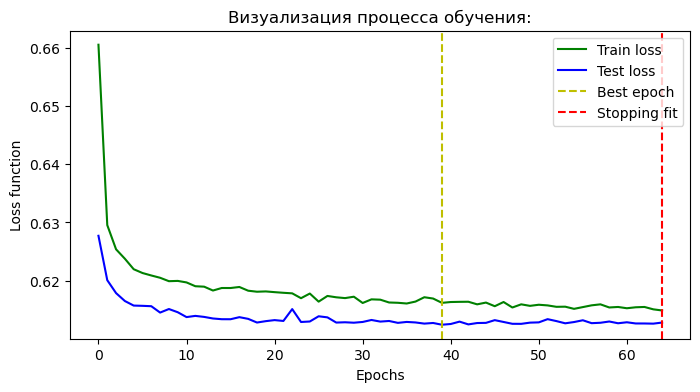

In [722]:
plt.figure(figsize=(8, 4))
plt.plot(result_test['train_loss'], color='green', label='Train loss')
plt.plot(result_test['test_loss'], color='blue', label='Test loss')

# отметка Best epoch
plt.axvline(x=result_test['best_epoch'], color='y', linestyle='--', label='Best epoch')
# отметка Stopping train
plt.axvline(x=result_test['stopping_epoch'], color='red', linestyle='--', label='Stopping fit')

plt.title('Визуализация процесса обучения:')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend(loc='best')
plt.show()

- Метрики качества моделb нейронной сети:
    - Accuracy: 0.64
    - Precision: 0.80
    - Recall: 0.32

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

## Сводная таблица метрик обучения моделей
</div>

In [729]:
data = {
    'Metrics': ['Accuracy', 'Precision', 'Recall'],
    'LogisticRegression': [round(accuracy_lr, 2), round(precision_lr, 2), round(recall_lr, 2)],
    'CatBoost': [round(accuracy_cb, 2), round(precision_cb, 2), round(recall_cb, 2)],
    'PyTorch_model': [round(accuracy_dl, 2), round(precision_dl, 2), round(recall_dl, 2)]
}
display(pd.DataFrame(data))

,Metrics,LogisticRegression,CatBoost,PyTorch_model
0,Accuracy,0.63,0.65,0.64
1,Precision,0.76,0.69,0.80
2,Recall,0.42,0.47,0.32


<div style="padding: 30px 25px; border: 2px #6495ed solid">

__Вывод:__

- Все модели обладают не высокой способностью определять, клиентов, которые стали причиной ДТП.
- Нашей основной целью является минимизация ложноотрицательных ответов модели (т.е., предсказание клиентов, которые стали причиной ДТП, но были определены моделью как 0), то в данной ситуации наилучший выбор, скорее всего, будет CatBoost:
    - Высокий Recall:  Recall важен в данном контексте, поскольку он показывает, как много положительных объектов (виновников ДТП) модель обнаружила из всех положительных объектов в данных. CatBoost показывает Recall 0.47, что означает, что модель правильно определяет около 47% всех виновников ДТП.
    - Относительно высокая точность: Несмотря на то, что Recall в CatBoost ниже, чем в PyTorch_model, его точность (Precision) также достаточно высока (0.69). Precision показывает, как много из всех объектов, которые модель предсказала как положительные, действительно являются положительными. Это важно, чтобы минимизировать ложноположительные ответы.

</div>

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Проверка модели на данных для тестирования
</div>

In [734]:
# train pool
test = Pool(data=X_test,
            cat_features=categorical_columns
            )
    
# предсказание
pred = model_cb.predict(test)
    
accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred, average='binary')

# вывод результатов
print(f'''Метрики CatBoost на тестовых данных:
Accuracy: {round(accuracy, 2)}
Precision: {round(precision, 2)}
Recall: {round(recall, 2)}''')

Метрики CatBoost на тестовых данных:
Accuracy: 0.66
Precision: 0.7
Recall: 0.49


- Метрики качества модели на тестовых данных подтверждают соответствие метрик, полученных на данных для обучения, что говорит о том, что модель адекватна и отсутствует переобучение.
- Accuracy (Точность) составляет 0.66, что означает, что модель правильно классифицировала 66% тестовых данных.
- Precision (Точность) составляет 0.7, что говорит о том, что из всех объектов, которые модель классифицировала как виновников ДТП, 70% действительно являются таковыми.
- Recall (Полнота) равен 0.49, что означает, что модель обнаруживает 49% всех действительных виновников ДТП из всех положительных случаев.

__Визуализация данных тестирования__

In [737]:
# получение матрицы ошибок
cm = confusion_matrix(y_test, pred)

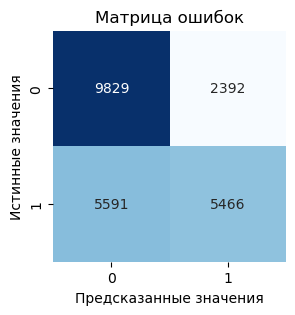

In [740]:
# визуализация матрицы ошибок
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Предсказанные значения")
plt.ylabel("Истинные значения")
plt.title("Матрица ошибок")
plt.show()

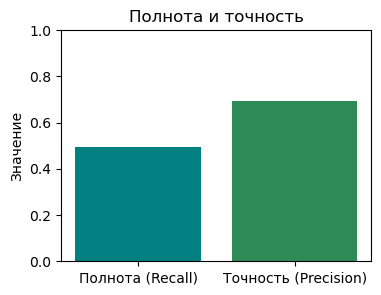

In [745]:
# визуализация Recall и Precision
plt.figure(figsize=(4, 3))
plt.bar(['Полнота (Recall)', 'Точность (Precision)'], [recall, precision], color=['teal', 'seagreen'])
plt.ylim(0, 1)
plt.ylabel('Значение')
plt.title('Полнота и точность')
plt.show()

- Модель имеет неплохую точность (Precision) в предсказании виновников ДТП (при условии, что она предсказывает "1"), что может быть полезным, чтобы уменьшить количество ложно положительных предсказаний.
- Однако, модель имеет относительно низкий Recall, что означает, что она не слишком хорошо обнаруживает реальных виновников ДТП (число ложно отрицательных предсказаний велико).

### Анализ важности основных факторов

Для анализа важности признаков и визуализации данных используем библиотеку SHAP (SHapley Additive exPlanations) 

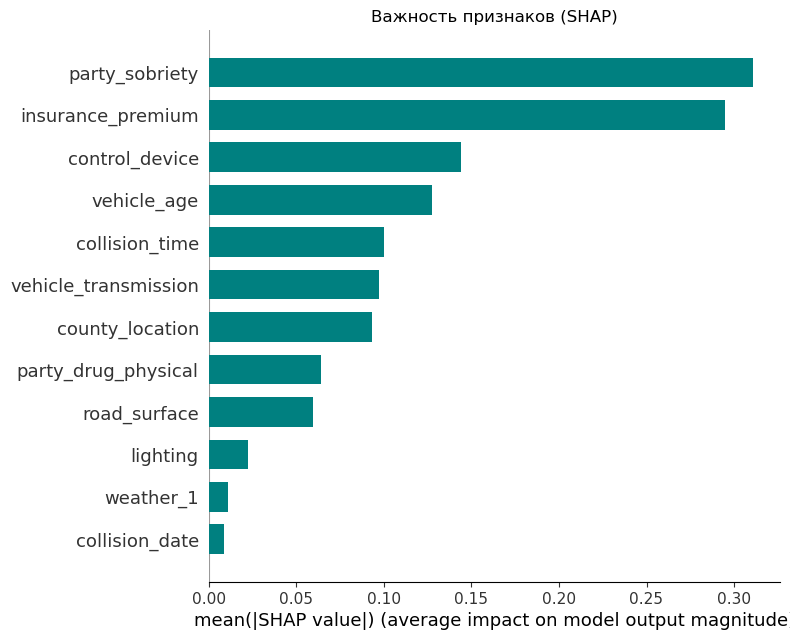

In [757]:
# инициализация Explainer
explainer = shap.Explainer(model_cb)

# получение значений SHAP для тестовых данных
shap_values = explainer.shap_values(X_test)

# визуализация SHAP значений
shap.summary_plot(shap_values, X_test, plot_type='bar', show=False, color='teal')
plt.title('Важность признаков (SHAP)')
plt.show()


Как видно из графика, самым главным признаком, влияющий на фак аварии является `party_sobriety` - трезвость участника, при предобработки данных мы разделили записи в зависимости от степени опьянения. Посмотрим зависимость вероятности стать виновником ДТП от уровня опьянения:

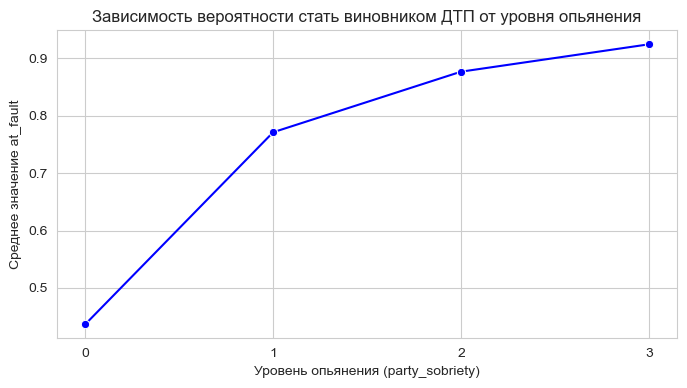

In [770]:
# сводная таблица для среднего значения 'at_fault' по уровню опьянения 'party_sobriety'
mean_at_fault = df.groupby('party_sobriety')['at_fault'].mean()

# построение графика
sns.set_style("whitegrid")
plt.figure(figsize=(8, 4))
sns.lineplot(x=mean_at_fault.index, y=mean_at_fault.values, marker='o', color='b')
plt.xlabel('Уровень опьянения (party_sobriety)')
plt.ylabel('Среднее значение at_fault')
plt.title('Зависимость вероятности стать виновником ДТП от уровня опьянения')
plt.xticks(mean_at_fault.index)
plt.show()

<div style="padding: 30px 25px; border: 2px #6495ed solid">

__Вывод:__

Из графика видно, что с увеличением уровня опьянения (от 0 до 3) вероятность стать виновником ДТП увеличивается. Чем выше уровень опьянения, тем больше вероятность попадания в аварию, где водитель считается виновным.

Чтобы учесть этот фактор во время посадки водителя, можно использовать различные технические средства и системы, такие как:

- Алкотестеры: Установка алкотестеров в автомобиле позволит водителю проверить свой уровень опьянения перед поездкой и принять решение о том, стоит ли ему садиться за руль.

- Автоматические системы блокировки двигателя: Эти системы могут быть настроены на блокировку двигателя, если уровень опьянения водителя превышает определенный уровень.

- Интеллектуальные сенсоры и системы мониторинга: Можно разработать системы, которые будут контролировать поведение водителя и выдавать предупреждения или автоматически предпринимать меры, если обнаружится признак опьянения.

- Системы предупреждения о состоянии водителя: Использование камер и сенсоров для мониторинга поведения водителя и выявления признаков усталости или опьянения.

Эти технологии и системы могут помочь снизить вероятность аварий, связанных с опьянением водителей, и повысить безопасность дорожного движения. Однако следует помнить, что самое эффективное средство предотвращения аварий - это не садиться за руль в состоянии опьянения.

</div>

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Вывод
</div>

В ходе анализа и построения моделей для предсказания столкновений на дороге и определения виновников ДТП, были рассмотрены три различные модели: Logistic Regression, CatBoost и PyTorch модель. Каждая из этих моделей основана на различных алгоритмах машинного обучения.


Лучшей моделью для предсказания виновников ДТП оказалась модель CatBoost. Она продемонстрировала наибольшую точность предсказания среди всех рассмотренных моделей, а именно:

- Accuracy: 0.66
- Precision: 0.7
- Recall: 0.49

Эти метрики говорят о том, что модель способна правильно предсказывать примерно 66% случаев, обнаруживая около 70% виновников и имея 49% полноту (способность находить всех виновников среди всех реальных виновников).

Использование предсказательных моделей, таких как CatBoost, может помочь оценить потенциальные риски для водителей, особенно в отношении вероятности стать виновником ДТП в зависимости от различных факторов, таких как уровень опьянения, возраст автомобиля и другие характеристики.

Однако стоит отметить, что любая модель предсказания имеет ограничения и может допускать ошибки. Поэтому необходимо рассматривать предсказания модели как инструмент для поддержки принятия решений, а не абсолютную истину. Важно также учитывать, что результаты предсказаний могут зависеть от качества данных, используемых для обучения модели.

Для улучшения модели и ее предсказательной способности можно рассмотреть следующие факторы:

- Дополнительные признаки: Добавление дополнительных признаков, характеристики водителя и окружающей среды, может улучшить способность модели предсказывать вероятность столкновений.

- Обогащение данных: Сбор дополнительных, более свежих данных и обогащение текущих данных может помочь улучшить качество модели и увеличить ее обобщающую способность.

- Дополнительные модели: Рассмотрение других типов моделей и алгоритмов машинного обучения может привести к улучшению результатов.

- Интерпретируемость моделей: Понимание того, как и почему модель принимает определенные решения, очень важно. Использование методов интерпретации, таких как SHAP, помогает понять важность различных факторов и признаков в принятии решений.


__Общий вывод:__

Создание адекватной системы оценки риска при аренде автомобиля - это важная задача для обеспечения безопасности на дорогах. Использование предсказательных моделей, таких как CatBoost, может помочь оценить риски и потенциальные проблемы, связанные с водителями. Однако следует помнить, что модели являются лишь инструментом, а не абсолютной истиной, и требуют постоянного улучшения и оптимизации на основе новых данных и обратной связи. Также необходимо учитывать ограничения моделей и контролировать качество данных, используемых для обучения.

